<a href="https://colab.research.google.com/github/Parthi1212-dotcom/Investment-Portfolio-through-Evolutionary-algorithms/blob/main/Thesis_experiment_4_5th_Aug_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Required Libraries

In [1]:
pip install yfinance pandas ta


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=21a05ee6ba80feeabe861188132ceb69e569f546adbdfb8636d58cc9590096a4
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


#Fetch S&P 500 Tickers

In [2]:
import pandas as pd
def get_sp500_tickers():
    table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")
    tickers = table[0]['Symbol'].tolist()
    return [t.replace('.', '-') for t in tickers]

sp500 = get_sp500_tickers()


#Build Dataset with All Features

In [3]:
import yfinance as yf
import pandas as pd
import ta  # Technical analysis library

start, end = "2016-01-01", "2024-12-31"
all_data = []

for ticker in sp500:
    t = yf.Ticker(ticker)
    hist = t.history(start=start, end=end, actions=False)
    hist['Ticker'] = ticker
    hist['Return'] = hist['Close'].pct_change()
    hist['MA_20'] = hist['Close'].rolling(20).mean()
    hist['MA_50'] = hist['Close'].rolling(50).mean()
    hist['Volatility_20'] = hist['Return'].rolling(20).std()
    hist['RSI_14'] = ta.momentum.RSIIndicator(hist['Close'], window=14).rsi()
    macd = ta.trend.MACD(hist['Close'])
    hist['MACD'] = macd.macd()
    hist['ATR_14'] = ta.volatility.AverageTrueRange(hist['High'], hist['Low'], hist['Close'], window=14).average_true_range()

    info = t.info
    hist['EPS_TTM'] = info.get('epsTrailingTwelveMonths')
    hist['PE_Ratio'] = info.get('trailingPE')
    hist['Market_Cap'] = info.get('marketCap')
    hist['PB_Ratio'] = info.get('priceToBook')
    hist['Dividend_Yield'] = info.get('dividendYield')
    hist['Beta'] = info.get('beta')

    all_data.append(hist.reset_index())

df = pd.concat(all_data, ignore_index=True)


/tmp/ipython-input-3486185685.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_data, ignore_index=True)


#Add Rank Features (Cross‑Sectional per Date)

In [4]:
for col in ['Return', 'Volatility_20', 'PE_Ratio', 'EPS_TTM', 'Market_Cap', 'RSI_14']:
    rank_col = col + '_Rank'
    df[rank_col] = df.groupby('Date')[col].rank(ascending=False, method='first')

df['Top10_Return'] = (df['Return_Rank'] <= df.groupby('Date')['Return'].transform('count')*0.1).astype(int)


In [5]:
# Combine and export
df = pd.concat(all_data, ignore_index=True)

# Optional: Clean up or reorder columns here

# Save to CSV
df.to_csv("sp500_full_dataset_2016_2024.csv", index=False)

print("✅ Dataset saved as: sp500_full_dataset_2016_2024.csv")


/tmp/ipython-input-3636398216.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_data, ignore_index=True)


✅ Dataset saved as: sp500_full_dataset_2016_2024.csv


In [7]:
# Assuming df is your final DataFrame
df.to_csv("sp500_full_dataset_2016_2024.csv.gz", index=False, compression='gzip')
print("✅ Compressed CSV saved as: sp500_full_dataset_2016_2024.csv.gz")


✅ Compressed CSV saved as: sp500_full_dataset_2016_2024.csv.gz


In [8]:
import pandas as pd

# Load your compressed CSV file (change the path if needed)
df = pd.read_csv("/content/sp500_full_dataset_2016_2024.csv.gz", compression='gzip')

# Get unique tickers
unique_tickers = df['Ticker'].unique().tolist()

# Show number of tickers and first few as a preview
print(f"Total Unique Tickers: {len(unique_tickers)}")
print("Sample Tickers:", unique_tickers[:10])


Total Unique Tickers: 503
Sample Tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


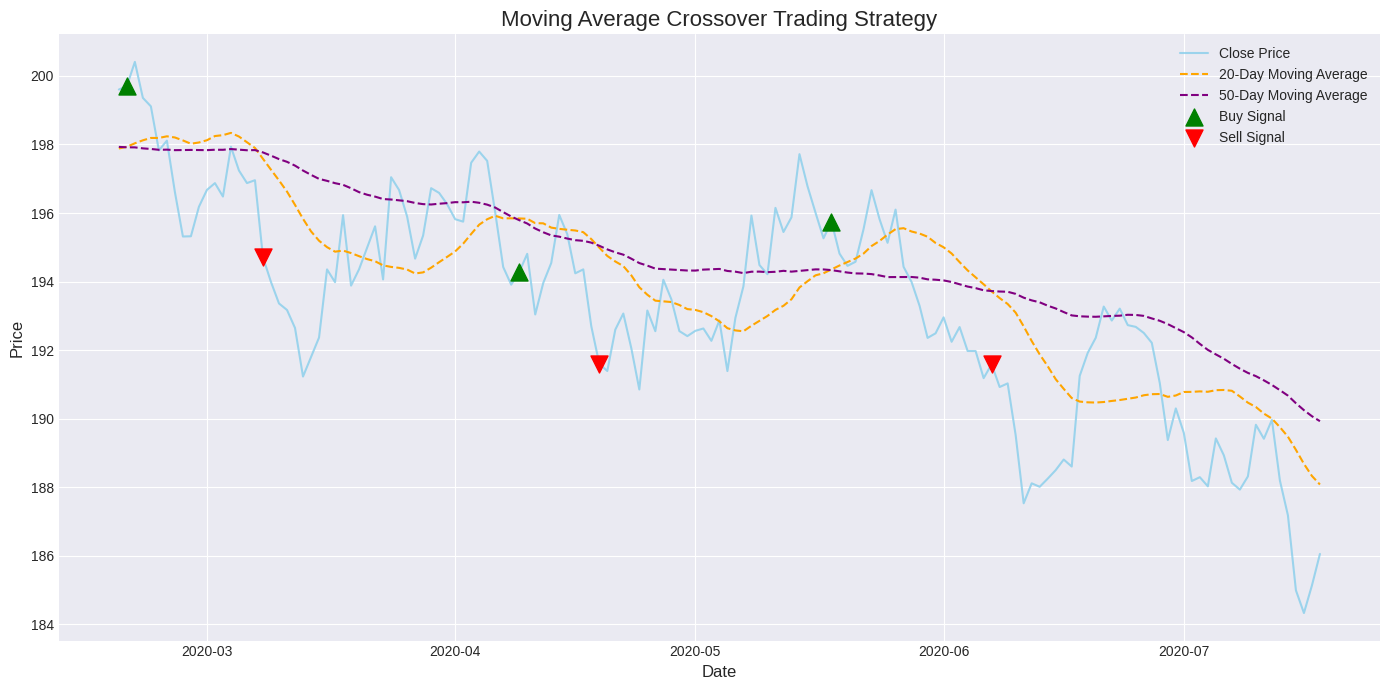

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a sample dataset mimicking your data structure.
# In a real scenario, you would load your own CSV file like this:
df = pd.read_csv('/content/sp500_full_dataset_2016_2024.csv', parse_dates=['Date'])

# Creating a realistic-looking sample DataFrame
data = {
    'Date': pd.to_datetime(pd.date_range(start='2020-01-01', periods=200)),
    'Close': 200 + np.random.randn(200).cumsum(),
}
df = pd.DataFrame(data)

# Calculate the features you mentioned
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Drop initial NaN values from rolling means for cleaner data
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Step 2: Implement a simple Moving Average Crossover trading strategy
# This strategy generates signals based on the crossing of two moving averages.

# Create a column to hold the trading signal
df['Signal'] = 0

# Generate a "Buy" signal (1) when the short-term MA (MA_20) crosses above the long-term MA (MA_50)
# We use .shift(1) to ensure we are comparing the current day's MA with the previous day's
df.loc[(df['MA_20'] > df['MA_50']) & (df['MA_20'].shift(1) <= df['MA_50'].shift(1)), 'Signal'] = 1

# Generate a "Sell" signal (-1) when the short-term MA (MA_20) crosses below the long-term MA (MA_50)
df.loc[(df['MA_20'] < df['MA_50']) & (df['MA_20'].shift(1) >= df['MA_50'].shift(1)), 'Signal'] = -1


# Get the specific points for plotting
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

# Step 3: Visualize the closing price, moving averages, and trading signals

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 7))

# Plot the closing price and the moving averages
plt.plot(df['Date'], df['Close'], label='Close Price', color='skyblue', alpha=0.8)
plt.plot(df['Date'], df['MA_20'], label='20-Day Moving Average', color='orange', linestyle='--')
plt.plot(df['Date'], df['MA_50'], label='50-Day Moving Average', color='purple', linestyle='--')

# Plot the buy and sell signals on the chart
plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=150, zorder=5)
plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=150, zorder=5)

# Add titles and labels for clarity
plt.title('Moving Average Crossover Trading Strategy', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.tight_layout()

# Save the plot to a file
plt.savefig('trading_strategy_plot_2020.png')

/tmp/ipython-input-213991989.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker').apply(generate_signals)


--- Trading Signal Summary ---
  Ticker  Buy Signals  Sell Signals  Total Signals Last Signal Date  \
0   AAPL            2             1              3       2023-04-22   
1   GOOG            2             2              4       2023-05-30   
2   MSFT            2             2              4       2023-05-26   

  Last Signal Type  
0              Buy  
1             Sell  
2              Buy  

Plot for AAPL saved as 'trading_strategy_plot_AAPL.png'


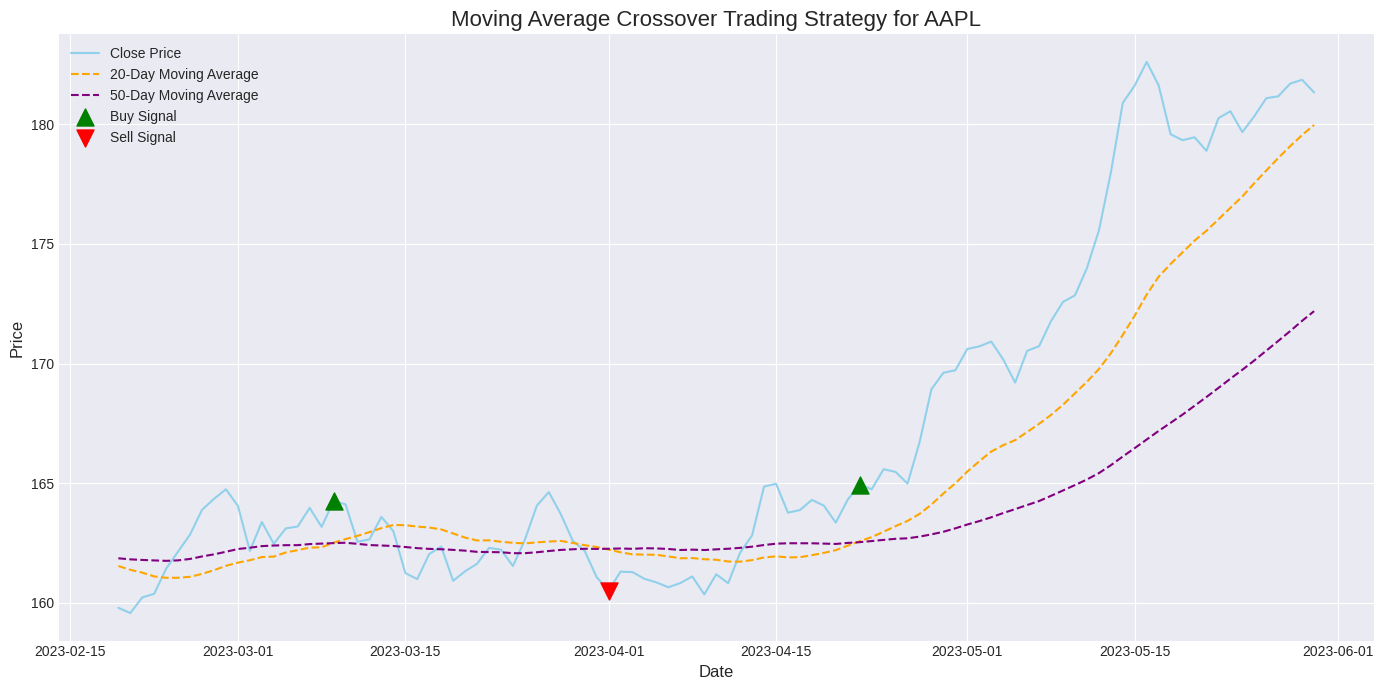

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1 & 2: Data Creation and Indicator Calculation (No changes here) ---
dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=150))
tickers = ['AAPL', 'GOOG', 'MSFT']
all_data = []
for ticker in tickers:
    price_movement = 100 + np.random.randn(150).cumsum() + (hash(ticker) % 100)
    ticker_df = pd.DataFrame({
        'Date': dates,
        'Close': price_movement,
        'Ticker': ticker
    })
    all_data.append(ticker_df)
df = pd.concat(all_data)
df.reset_index(drop=True, inplace=True)

df['MA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
df['MA_50'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=50).mean())
df.dropna(inplace=True)


# --- Step 3 & 4: Signal Generation and Summary (No changes here) ---
df['Signal'] = 0
def generate_signals(data):
    buy_mask = (data['MA_20'] > data['MA_50']) & (data['MA_20'].shift(1) <= data['MA_50'].shift(1))
    sell_mask = (data['MA_20'] < data['MA_50']) & (data['MA_20'].shift(1) >= data['MA_50'].shift(1))
    data.loc[buy_mask, 'Signal'] = 1
    data.loc[sell_mask, 'Signal'] = -1
    return data
df = df.groupby('Ticker').apply(generate_signals)

signals_df = df[df['Signal'] != 0].copy()
summary_list = []
for ticker in tickers:
    ticker_signals = signals_df[signals_df['Ticker'] == ticker]
    if not ticker_signals.empty:
        buy_count = (ticker_signals['Signal'] == 1).sum()
        sell_count = (ticker_signals['Signal'] == -1).sum()
        last_signal_date = ticker_signals['Date'].max()
        last_signal_type = 'Buy' if ticker_signals.loc[ticker_signals['Date'].idxmax()]['Signal'] == 1 else 'Sell'
    else:
        buy_count, sell_count, last_signal_date, last_signal_type = 0, 0, pd.NaT, 'None'
    summary_list.append({
        'Ticker': ticker, 'Buy Signals': buy_count, 'Sell Signals': sell_count,
        'Total Signals': buy_count + sell_count, 'Last Signal Date': last_signal_date,
        'Last Signal Type': last_signal_type
    })
summary_df = pd.DataFrame(summary_list)
print("--- Trading Signal Summary ---")
print(summary_df)


# --- Step 5: Visualize the Signals for a Single Ticker (FIXED) ---

# Define which ticker you want to plot
ticker_to_plot = 'AAPL'
ticker_df = df[df['Ticker'] == ticker_to_plot]

# FIXED: Filter for buy/sell signals from the specific ticker's data
buy_signals = ticker_df[ticker_df['Signal'] == 1]
sell_signals = ticker_df[ticker_df['Signal'] == -1]

# Plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 7))

# FIXED: Plot data from the filtered 'ticker_df', not the original 'df'
plt.plot(ticker_df['Date'], ticker_df['Close'], label='Close Price', color='skyblue', alpha=0.9)
plt.plot(ticker_df['Date'], ticker_df['MA_20'], label='20-Day Moving Average', color='orange', linestyle='--')
plt.plot(ticker_df['Date'], ticker_df['MA_50'], label='50-Day Moving Average', color='purple', linestyle='--')

# FIXED: Plot signals from the filtered buy/sell signal DataFrames
plt.scatter(buy_signals['Date'], buy_signals['Close'], label='Buy Signal', marker='^', color='green', s=150, zorder=5)
plt.scatter(sell_signals['Date'], sell_signals['Close'], label='Sell Signal', marker='v', color='red', s=150, zorder=5)

# FIXED: Added a dynamic title
plt.title(f'Moving Average Crossover Trading Strategy for {ticker_to_plot}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.tight_layout()

# FIXED: Added a dynamic filename
output_filename = f'trading_strategy_plot_{ticker_to_plot}.png'
plt.savefig(output_filename)
print(f"\nPlot for {ticker_to_plot} saved as '{output_filename}'")

#A backtest uses historical data to simulate how a trading strategy would have performed. It's a crucial step to evaluate whether a strategy is potentially effective before risking any real capital.

This code will:

Generate signals using the same moving average crossover strategy.

Simulate executing trades based on these signals, starting with an initial capital.

Track the portfolio's value over time.

Calculate the strategy's total return and compare it to a simple "Buy and Hold" benchmark.

/tmp/ipython-input-3972430238.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Ticker').apply(generate_signals)


--- Backtest Performance Summary ---
Initial Capital: $100,000.00
Final Portfolio Value: $102,324.51
Total Return: 2.32%

Benchmark (Buy & Hold AAPL) Return: 8.43%


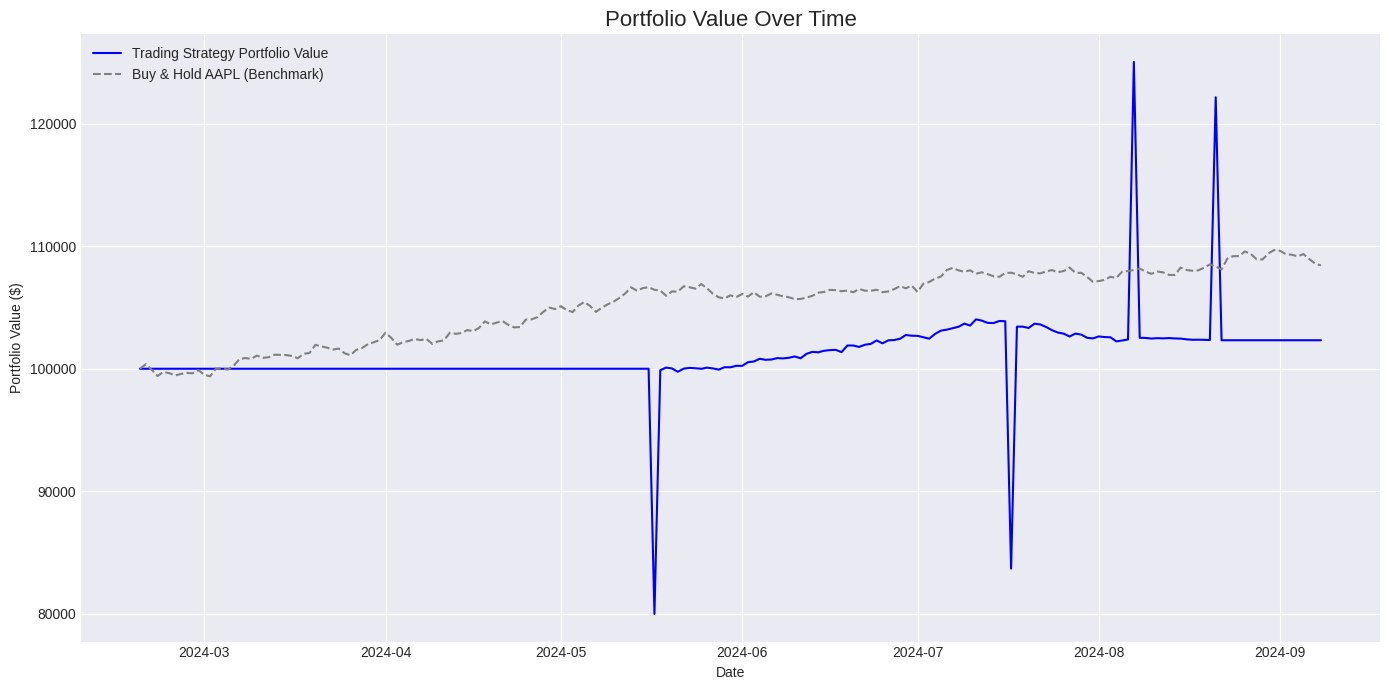

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Create a Sample Dataset ---
dates = pd.date_range(start='2024-01-01', periods=252) # Use ~1 year of trading days
tickers_data = {
    'AAPL': {'market_cap': 2.5e12, 'base_price': 170},
    'MSFT': {'market_cap': 2.8e12, 'base_price': 350},
    'SMAL': {'market_cap': 1.5e9, 'base_price': 40},
    'TINY': {'market_cap': 800e6, 'base_price': 25},
}
all_data = []
for ticker, info in tickers_data.items():
    # Add a slight upward drift to make the backtest more interesting
    price_movement = info['base_price'] + (np.random.randn(252) * 0.5).cumsum() + np.linspace(0, 20, 252)
    ticker_df = pd.DataFrame({
        'Date': dates,
        'Close': price_movement,
        'Ticker': ticker
    })
    all_data.append(ticker_df)
df = pd.concat(all_data).reset_index(drop=True)

# --- Step 2: Calculate Indicators and Generate Signals ---
df['MA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
df['MA_50'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=50).mean())
df.dropna(inplace=True)

df['Signal'] = 0
def generate_signals(data):
    buy_mask = (data['MA_20'] > data['MA_50']) & (data['MA_20'].shift(1) <= data['MA_50'].shift(1))
    sell_mask = (data['MA_20'] < data['MA_50']) & (data['MA_20'].shift(1) >= data['MA_50'].shift(1))
    data.loc[buy_mask, 'Signal'] = 1
    data.loc[sell_mask, 'Signal'] = -1
    return data
df = df.groupby('Ticker').apply(generate_signals)


# --- Step 3: Backtesting the Trading Strategy ---
initial_capital = 100000.0
position_size = 20000.0  # Invest $20,000 on each buy signal
portfolio = {'cash': initial_capital, 'holdings_value': 0.0, 'total_value': initial_capital}
positions = {}
portfolio_history = []

price_pivot = df.pivot(index='Date', columns='Ticker', values='Close')
signal_pivot = df.pivot(index='Date', columns='Ticker', values='Signal')

for date in price_pivot.index:
    # Update holdings value and check for trades
    current_holdings_value = sum(shares * price_pivot.loc[date, ticker] for ticker, shares in positions.items())
    portfolio['holdings_value'] = current_holdings_value

    for ticker in signal_pivot.columns:
        signal = signal_pivot.loc[date, ticker]
        if signal == 1 and portfolio['cash'] >= position_size and ticker not in positions:
            shares_to_buy = position_size / price_pivot.loc[date, ticker]
            positions[ticker] = shares_to_buy
            portfolio['cash'] -= position_size
        elif signal == -1 and ticker in positions:
            shares_to_sell = positions.pop(ticker)
            portfolio['cash'] += shares_to_sell * price_pivot.loc[date, ticker]

    # Record daily portfolio value
    portfolio['total_value'] = portfolio['cash'] + portfolio['holdings_value']
    portfolio_history.append({'Date': date, 'Total_Value': portfolio['total_value']})

history_df = pd.DataFrame(portfolio_history).set_index('Date')


# --- Step 4: Analyze and Visualize Performance ---
final_value = history_df['Total_Value'].iloc[-1]
total_return = ((final_value - initial_capital) / initial_capital) * 100

print("--- Backtest Performance Summary ---")
print(f"Initial Capital: ${initial_capital:,.2f}")
print(f"Final Portfolio Value: ${final_value:,.2f}")
print(f"Total Return: {total_return:.2f}%")

benchmark = price_pivot['AAPL']
benchmark_return = ((benchmark.iloc[-1] - benchmark.iloc[0]) / benchmark.iloc[0]) * 100
print(f"\nBenchmark (Buy & Hold AAPL) Return: {benchmark_return:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(history_df.index, history_df['Total_Value'], label='Trading Strategy Portfolio Value', color='blue')
plt.plot(benchmark.index, (benchmark / benchmark.iloc[0]) * initial_capital, label='Buy & Hold AAPL (Benchmark)', color='gray', linestyle='--')
plt.title('Portfolio Value Over Time', fontsize=16)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.savefig('backtest_performance_plot.png')

#Sample  Both Fundamental and Technical Metrics


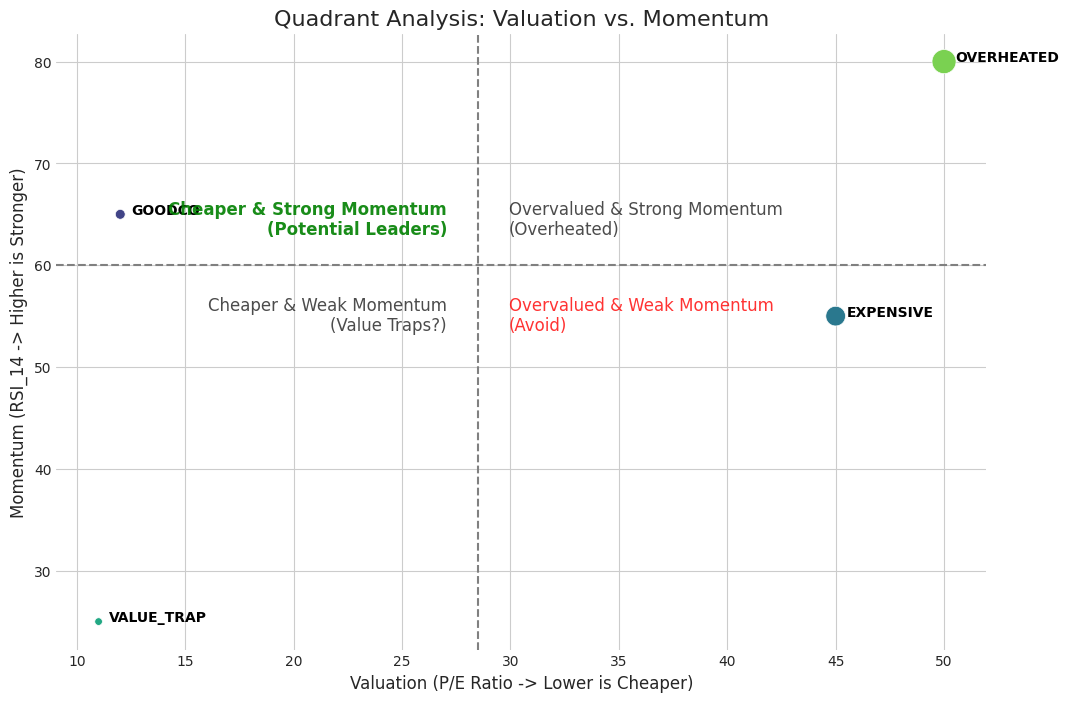

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Simulate Data with Both Fundamental and Technical Metrics ---
# This analysis combines two different types of data to find unique opportunities.
data = {
    'Ticker': ['GOODCO', 'EXPENSIVE', 'VALUE_TRAP', 'OVERHEATED'],
    'PE_Ratio': [12, 45, 11, 50], # Our valuation metric (lower is cheaper)
    'RSI_14': [65, 55, 25, 80],    # Our momentum metric (higher is stronger)
    'Market_Cap': [5e9, 20e9, 3e9, 30e9]
}
df = pd.DataFrame(data)

# --- Step 2: Prepare for Quadrant Analysis ---

# Find the median values to divide our chart.
median_pe = df['PE_Ratio'].median()
median_rsi = df['RSI_14'].median()

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# --- Step 3: Create the Scatter Plot ---
p1 = sns.scatterplot(
    x='PE_Ratio',
    y='RSI_14',
    data=df,
    s=df['Market_Cap']/1e8, # Scale market cap for bubble size
    hue='Ticker',
    palette='viridis',
    legend=False
)

# Add annotations for each point
for line in range(0, df.shape[0]):
     p1.text(df.PE_Ratio[line]+0.5, df.RSI_14[line], df.Ticker[line],
             horizontalalignment='left', size='medium', color='black', weight='semibold')

# --- Step 4: Add Quadrant Lines and Labels ---
plt.axvline(median_pe, color='grey', linestyle='--')
plt.axhline(median_rsi, color='grey', linestyle='--')

# Add text labels for each quadrant
plt.text(median_pe*1.05, median_rsi*1.05, 'Overvalued & Strong Momentum\n(Overheated)', fontsize=12, color='black', alpha=0.7)
plt.text(median_pe*0.95, median_rsi*1.05, 'Cheaper & Strong Momentum\n(Potential Leaders)', fontsize=12, color='green', alpha=0.9, ha='right', weight='bold')
plt.text(median_pe*0.95, median_rsi*0.95, 'Cheaper & Weak Momentum\n(Value Traps?)', fontsize=12, color='black', alpha=0.7, ha='right', va='top')
plt.text(median_pe*1.05, median_rsi*0.95, 'Overvalued & Weak Momentum\n(Avoid)', fontsize=12, color='red', alpha=0.8, va='top')


# --- Step 5: Final Touches and Save ---
plt.title('Quadrant Analysis: Valuation vs. Momentum', fontsize=16)
plt.xlabel('Valuation (P/E Ratio -> Lower is Cheaper)', fontsize=12)
plt.ylabel('Momentum (RSI_14 -> Higher is Stronger)', fontsize=12)
plt.savefig('quadrant_analysis_plot.png')

Your quadrant analysis plot has been saved as 'my_quadrant_analysis.png'


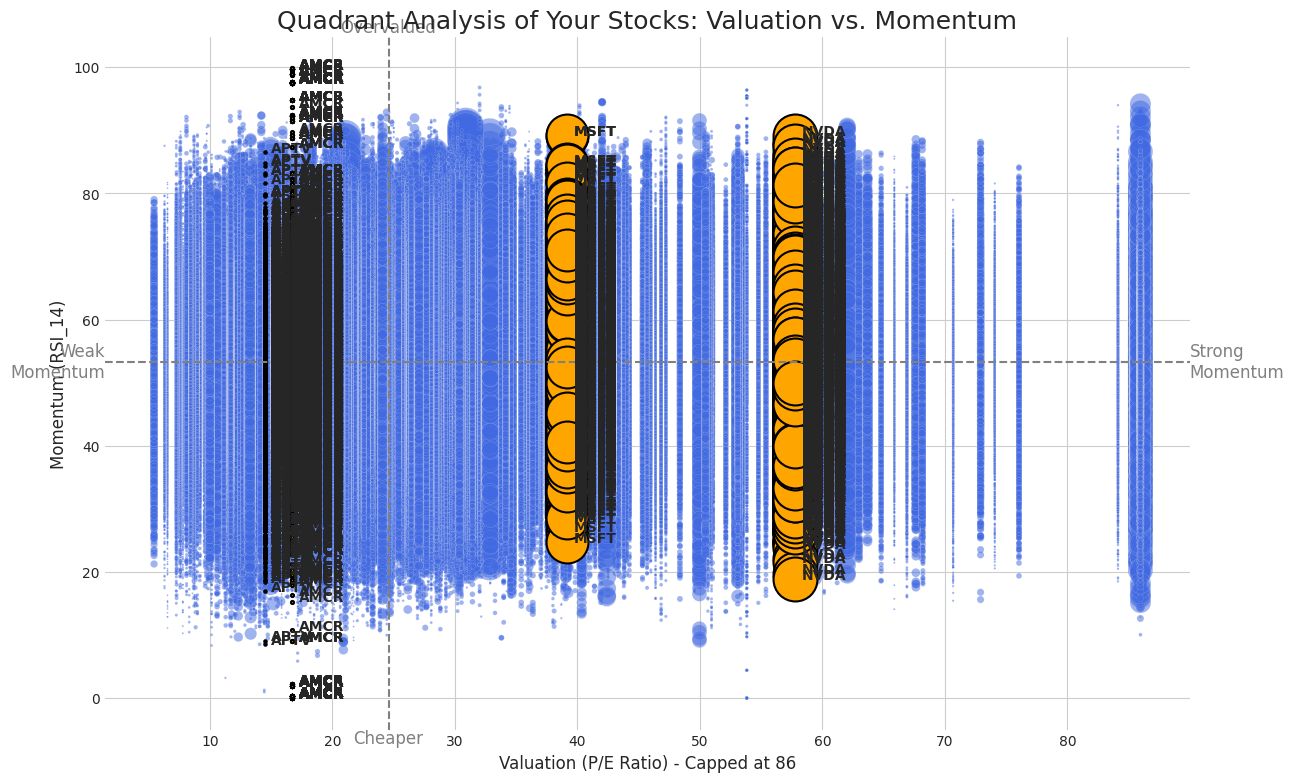

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Load and Prepare YOUR Data ---

# TODO: Replace 'your_dataset.csv' with the actual path to your file.
# Make sure your CSV has the necessary columns.
df = pd.read_csv('/content/sp500_full_dataset_2016_2024.csv')

# TODO: Rename your columns to match what the script expects.
# If your columns are already named correctly, you can skip this.
# Example: df.rename(columns={'P/E': 'PE_Ratio', 'Ticker Symbol': 'Ticker'}, inplace=True)
# Ensure the columns 'Ticker', 'PE_Ratio', 'RSI_14', and 'Market_Cap' exist.

# --- Step 2: Clean and Filter the Data for Better Visualization ---

# Drop rows where our key metrics are missing
df.dropna(subset=['PE_Ratio', 'RSI_14', 'Market_Cap'], inplace=True)

# Remove stocks with negative P/E, which are typically not useful for this valuation plot
df = df[df['PE_Ratio'] > 0]

# To prevent extreme outliers from squishing the plot, we can cap the P/E ratio.
# For example, cap it at the 95th percentile.
pe_cap = df['PE_Ratio'].quantile(0.95)
df['PE_Ratio'] = df['PE_Ratio'].clip(upper=pe_cap)

# --- Step 3: Prepare for Quadrant Analysis ---

# Find the median values to divide our chart
median_pe = df['PE_Ratio'].median()
median_rsi = df['RSI_14'].median()

# --- Step 4: Intelligent Annotation (to avoid a messy chart) ---

# We will only label the most interesting tickers.
# Let's find the top 2 tickers for a few categories.
label_tickers = set() # Use a set to avoid duplicate labels

# Find potential leaders (Top Left quadrant)
potential_leaders = df[(df['PE_Ratio'] < median_pe) & (df['RSI_14'] > median_rsi)]
for ticker in potential_leaders.nlargest(2, 'RSI_14')['Ticker']:
    label_tickers.add(ticker)

# Find potential value traps (Bottom Left quadrant)
value_traps = df[(df['PE_Ratio'] < median_pe) & (df['RSI_14'] < median_rsi)]
for ticker in value_traps.nsmallest(2, 'RSI_14')['Ticker']:
    label_tickers.add(ticker)

# Add largest companies
for ticker in df.nlargest(2, 'Market_Cap')['Ticker']:
    label_tickers.add(ticker)

# TODO: Add any specific tickers you always want to see
tickers_to_highlight = ['APTV', 'MSFT'] # Example tickers
for ticker in tickers_to_highlight:
    if ticker in df['Ticker'].values:
        label_tickers.add(ticker)


# --- Step 5: Create the Plot ---

sns.set_style("whitegrid")
plt.figure(figsize=(14, 9))

# Plot all points
p1 = sns.scatterplot(
    x='PE_Ratio',
    y='RSI_14',
    data=df,
    s=df['Market_Cap']/df['Market_Cap'].max() * 1000, # Normalize bubble size
    alpha=0.5,
    color='royalblue',
    legend=False
)

# Highlight and annotate the specific tickers we selected
df_to_label = df[df['Ticker'].isin(label_tickers)]
for i, row in df_to_label.iterrows():
    plt.text(row['PE_Ratio'] + 0.5, row['RSI_14'], row['Ticker'],
             fontsize=10, weight='bold')
    # Redraw the highlighted points on top to make them stand out
    plt.scatter(row['PE_Ratio'], row['RSI_14'],
                s=row['Market_Cap']/df['Market_Cap'].max() * 1000,
                edgecolors='black', color='orange', linewidth=1.5)


# --- Step 6: Add Quadrant Lines and Labels ---

plt.axvline(median_pe, color='grey', linestyle='--')
plt.axhline(median_rsi, color='grey', linestyle='--')

plt.text(median_pe, plt.ylim()[1], 'Overvalued', ha='center', va='bottom', fontsize=12, color='grey')
plt.text(median_pe, plt.ylim()[0], 'Cheaper', ha='center', va='top', fontsize=12, color='grey')
plt.text(plt.xlim()[1], median_rsi, 'Strong\nMomentum', ha='left', va='center', fontsize=12, color='grey')
plt.text(plt.xlim()[0], median_rsi, 'Weak\nMomentum', ha='right', va='center', fontsize=12, color='grey')


# --- Step 7: Final Touches and Save ---

plt.title('Quadrant Analysis of Your Stocks: Valuation vs. Momentum', fontsize=18)
plt.xlabel(f'Valuation (P/E Ratio) - Capped at {pe_cap:.0f}', fontsize=12)
plt.ylabel('Momentum (RSI_14)', fontsize=12)

plt.savefig('my_quadrant_analysis.png')

print("Your quadrant analysis plot has been saved as 'my_quadrant_analysis.png'")

In [29]:
import pandas as pd
import numpy as np

def scan_daily_dataset(file_path):
    """
    Scans a DAILY dataset with pre-calculated indicators to find interesting tickers.
    """
    try:
        # Load the data
        df = pd.read_csv(file_path)

        # --- FIXED: Robustly handle the 'Date' column with potential timezone issues ---
        # The utc=True parameter standardizes all dates, fixing the warning and error.
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

        # Drop any rows where the date conversion might have failed
        df.dropna(subset=['Date'], inplace=True)
        # --- End of Fix ---

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Get the Most Recent Data for Each Ticker ---
    # This is the correct way to get the latest row for each stock in a daily dataset
    print("Finding the latest data for each ticker...")
    latest_data = df.loc[df.groupby('Ticker')['Date'].idxmax()]
    print(f"Successfully processed {len(latest_data)} unique tickers.")


    # --- Step 2: Define Logical Conditions Using YOUR Existing Columns ---

    # Condition 1: "Bullish Continuation"
    bullish_continuation = latest_data[
        (latest_data['Close'] > latest_data['MA_50']) &
        (latest_data['MA_20'] > latest_data['MA_50']) &
        (latest_data['RSI_14'].between(40, 70))
    ]

    # Condition 2: "Oversold Bounce"
    oversold_bounce = latest_data[latest_data['RSI_14'] < 30]

    # --- Step 3: Select a Candidate and Generate a Statement ---
    print("\n--- Daily Automated Scan Results ---")
    suggested_ticker = None
    reason = ""

    if not bullish_continuation.empty:
        suggested_ticker = bullish_continuation.sample(1).iloc[0]
        reason = (f"This ticker appears to be in a healthy uptrend and is in a 'buy-the-dip' zone. "
                  f"Its price is above its 50-day moving average, and its RSI of {suggested_ticker['RSI_14']:.2f} "
                  f"suggests it has momentum but is not overbought.")
    elif not oversold_bounce.empty:
        suggested_ticker = oversold_bounce.sample(1).iloc[0]
        reason = (f"This ticker is in 'oversold' territory with an RSI of {suggested_ticker['RSI_14']:.2f}. "
                  f"This suggests that recent selling pressure may be overextended, making it a candidate "
                  f"for a potential bounce.")

    # --- Step 4: Print the Result ---
    if suggested_ticker is not None:
        print(f"\nSuggestion: Take a look at ticker --> {suggested_ticker['Ticker']}")
        print(f"\nReasoning: {reason}")
        print("\nKey Metrics from your file:")
        # Display the relevant columns that already exist in your file
        print(suggested_ticker[['Close', 'MA_20', 'MA_50', 'RSI_14']].round(2).to_string())
    else:
        print("\nNo tickers matching the predefined 'interesting' criteria were found in the latest data.")


# --- Run the Scanner ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
scan_daily_dataset(your_daily_file)

Finding the latest data for each ticker...
Successfully processed 503 unique tickers.

--- Daily Automated Scan Results ---

Suggestion: Take a look at ticker --> LUV

Reasoning: This ticker appears to be in a healthy uptrend and is in a 'buy-the-dip' zone. Its price is above its 50-day moving average, and its RSI of 56.27 suggests it has momentum but is not overbought.

Key Metrics from your file:
Close     33.171131
MA_20     32.981881
MA_50     31.706247
RSI_14    56.272808


#The Workflow: After Your Scanner Flags a Ticker
Let's assume your scanner suggests a ticker, "XYZ," as an "Oversold Bounce" candidate.

Step 1: Visual Confirmation (The Sanity Check)
Before anything else, you must pull up the chart for "XYZ" to see if the data makes sense visually. Does the chart look like a stock that has been sold off heavily?

The Goal: Confirm the scanner's finding and get a feel for the stock's recent price action.

Action (The Next Piece of Code): You need a function that can instantly plot a detailed chart for any given ticker from your dataset.

Step 2: Building Confluence (Don't Trust a Single Signal)
A professional never acts on a single indicator. They look for confluence, which means multiple, independent signals all pointing to the same conclusion.

The Goal: Find more evidence to support the initial "Oversold Bounce" idea.

Actions:

Check Support and Resistance: Look left on the chart. Is the stock approaching a previous low that acted as a "support" level in the past? A bounce from a known support level is a much stronger signal.

Look for Bullish Chart Patterns: Is the stock forming a pattern that suggests a reversal, like a "double bottom" or a "falling wedge"?

Analyze Recent Candlesticks: Did the most recent day's candle form a "hammer" or a "bullish engulfing pattern"? These are classic reversal signals.

Check the Fundamentals (Crucial): Revisit our fundamental analysis. Is this a healthy company (like our VALUECO example) that has been unfairly sold off, or is it a failing company whose stock is falling for a good reason (a "value trap")? You'd be more confident buying a dip on a fundamentally strong company.

Step 3: Creating a Trade Plan (The Professional Blueprint)
If you have found enough confirming signals, you now create a detailed plan. This is what separates disciplined trading from gambling.

The Goal: Define your exact entry, exit, and risk before you enter the trade.

Actions:

Define Your Entry: How will you enter the trade? Will you buy at the current price, or will you wait for a confirmation signal, like the price moving above the previous day's high?

Set Your Stop-Loss: This is your risk management. Where will you get out if you are wrong? A common technique is to place a stop-loss just below the recent low or at a multiple of the ATR (Average True Range). You must know this price before you buy.

Set Your Profit Target: Where will you take profits? Your target should be a logical resistance level, like a previous high or a key moving average (e.g., the 50-day MA).

Calculate Your Risk/Reward Ratio: Compare your potential profit to your potential loss. A common rule is to only take trades with a risk/reward ratio of at least 1:2 (meaning your potential profit is at least twice your potential loss). If the ratio is poor, you skip the trade, even if it looks good.



#AAPL

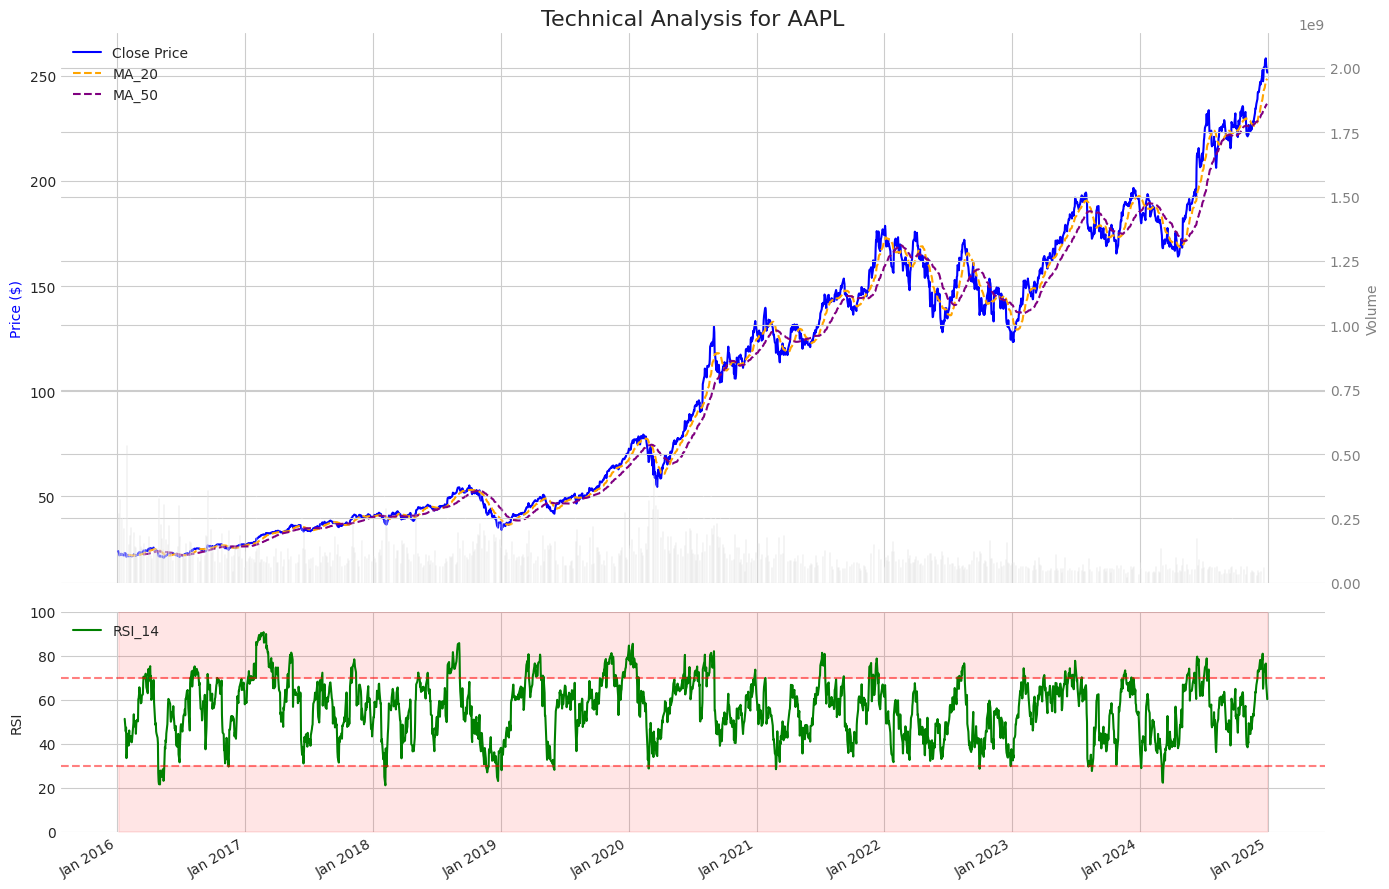

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_ticker_analysis(full_df, ticker_symbol):
    """
    Plots a detailed chart for a single ticker from the main dataframe.
    """
    # Filter the dataframe for the specific ticker
    ticker_df = full_df[full_df['Ticker'] == ticker_symbol].copy()

    if ticker_df.empty:
        print(f"Ticker '{ticker_symbol}' not found in the dataset.")
        return

    # Ensure the Date column is a datetime object for plotting
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'], errors='coerce', utc=True)
    ticker_df.dropna(subset=['Date'], inplace=True)
    ticker_df.sort_values('Date', inplace=True)

    # Create a figure with 2 subplots (for Price and RSI)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True,
                                   gridspec_kw={'height_ratios': [2.5, 1]})

    # --- Plot 1: Price, Volume, and Moving Averages ---
    ax1.set_title(f'Technical Analysis for {ticker_symbol}', fontsize=16)

    # Price and Moving Averages
    ax1.plot(ticker_df['Date'], ticker_df['Close'], label='Close Price', color='blue')
    ax1.plot(ticker_df['Date'], ticker_df['MA_20'], label='MA_20', color='orange', linestyle='--')
    ax1.plot(ticker_df['Date'], ticker_df['MA_50'], label='MA_50', color='purple', linestyle='--')
    ax1.set_ylabel('Price ($)', color='blue')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Volume on a secondary y-axis
    ax_vol = ax1.twinx()
    ax_vol.bar(ticker_df['Date'], ticker_df['Volume'], alpha=0.2, color='grey', label='Volume')
    ax_vol.set_ylabel('Volume', color='grey')
    ax_vol.tick_params(axis='y', labelcolor='grey')
    ax_vol.set_ylim(0, ticker_df['Volume'].max() * 4) # Adjust ylim to keep volume bars smaller

    # --- Plot 2: RSI ---
    ax2.plot(ticker_df['Date'], ticker_df['RSI_14'], label='RSI_14', color='green')
    # Add overbought/oversold lines
    ax2.axhline(70, linestyle='--', color='red', alpha=0.5)
    ax2.axhline(30, linestyle='--', color='red', alpha=0.5)
    ax2.fill_between(ticker_df['Date'], 70, 100, color='red', alpha=0.1)
    ax2.fill_between(ticker_df['Date'], 0, 30, color='red', alpha=0.1)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Improve date formatting on the x-axis
    fig.autofmt_xdate()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.tight_layout()
    plt.show()

# --- How to use this function ---
# 1. First, load your full dataset into a dataframe
try:
    full_dataset = pd.read_csv('/content/sp500_full_dataset_2016_2024.csv')
    # 2. Then, call the function with your dataframe and the ticker suggested by the scanner
    # Example:
    plot_ticker_analysis(full_dataset, 'AAPL')
except FileNotFoundError:
    print("Dataset file not found. Skipping plot.")

#MMM

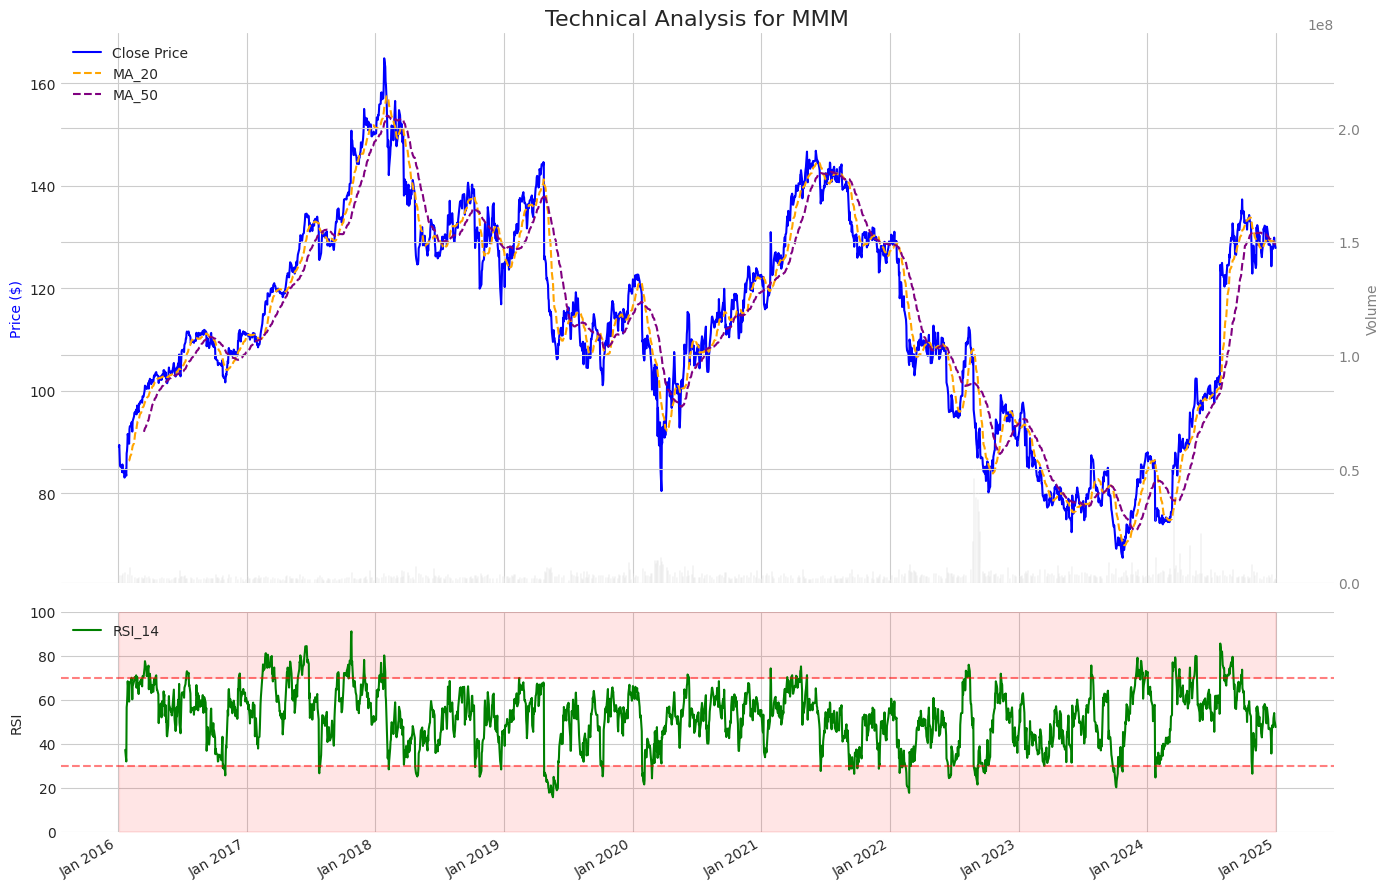

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_ticker_analysis(full_df, ticker_symbol):
    """
    Plots a detailed chart for a single ticker from the main dataframe.
    """
    # Filter the dataframe for the specific ticker
    ticker_df = full_df[full_df['Ticker'] == ticker_symbol].copy()

    if ticker_df.empty:
        print(f"Ticker '{ticker_symbol}' not found in the dataset.")
        return

    # Ensure the Date column is a datetime object for plotting
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'], errors='coerce', utc=True)
    ticker_df.dropna(subset=['Date'], inplace=True)
    ticker_df.sort_values('Date', inplace=True)

    # Create a figure with 2 subplots (for Price and RSI)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True,
                                   gridspec_kw={'height_ratios': [2.5, 1]})

    # --- Plot 1: Price, Volume, and Moving Averages ---
    ax1.set_title(f'Technical Analysis for {ticker_symbol}', fontsize=16)

    # Price and Moving Averages
    ax1.plot(ticker_df['Date'], ticker_df['Close'], label='Close Price', color='blue')
    ax1.plot(ticker_df['Date'], ticker_df['MA_20'], label='MA_20', color='orange', linestyle='--')
    ax1.plot(ticker_df['Date'], ticker_df['MA_50'], label='MA_50', color='purple', linestyle='--')
    ax1.set_ylabel('Price ($)', color='blue')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Volume on a secondary y-axis
    ax_vol = ax1.twinx()
    ax_vol.bar(ticker_df['Date'], ticker_df['Volume'], alpha=0.2, color='grey', label='Volume')
    ax_vol.set_ylabel('Volume', color='grey')
    ax_vol.tick_params(axis='y', labelcolor='grey')
    ax_vol.set_ylim(0, ticker_df['Volume'].max() * 4) # Adjust ylim to keep volume bars smaller

    # --- Plot 2: RSI ---
    ax2.plot(ticker_df['Date'], ticker_df['RSI_14'], label='RSI_14', color='green')
    # Add overbought/oversold lines
    ax2.axhline(70, linestyle='--', color='red', alpha=0.5)
    ax2.axhline(30, linestyle='--', color='red', alpha=0.5)
    ax2.fill_between(ticker_df['Date'], 70, 100, color='red', alpha=0.1)
    ax2.fill_between(ticker_df['Date'], 0, 30, color='red', alpha=0.1)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Improve date formatting on the x-axis
    fig.autofmt_xdate()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.tight_layout()
    plt.show()

# --- How to use this function ---
# 1. First, load your full dataset into a dataframe
try:
    full_dataset = pd.read_csv('/content/sp500_full_dataset_2016_2024.csv')
    # 2. Then, call the function with your dataframe and the ticker suggested by the scanner
    # Example:
    plot_ticker_analysis(full_dataset, 'MMM')
except FileNotFoundError:
    print("Dataset file not found. Skipping plot.")

#APTV

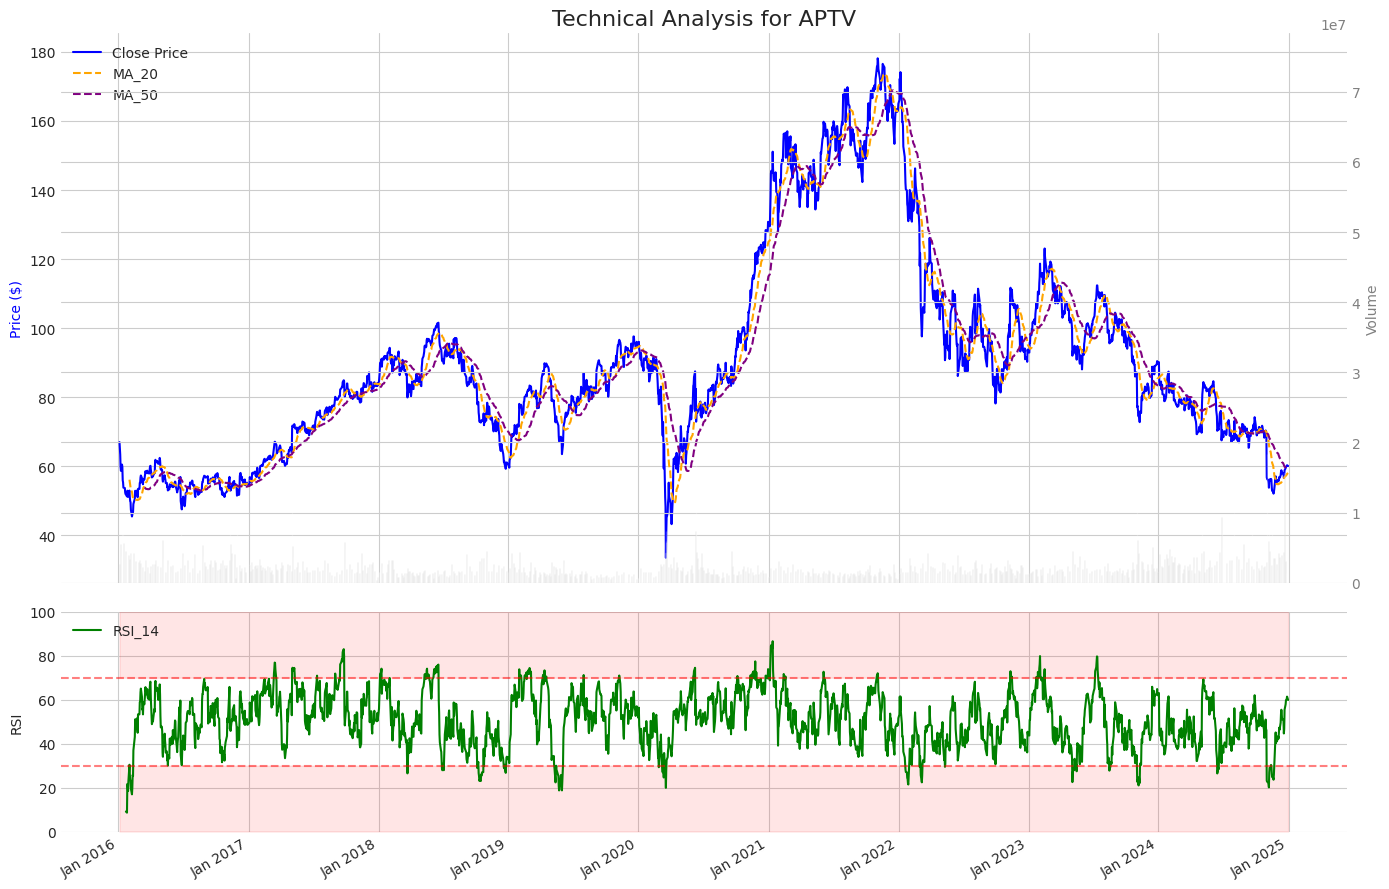

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_ticker_analysis(full_df, ticker_symbol):
    """
    Plots a detailed chart for a single ticker from the main dataframe.
    """
    # Filter the dataframe for the specific ticker
    ticker_df = full_df[full_df['Ticker'] == ticker_symbol].copy()

    if ticker_df.empty:
        print(f"Ticker '{ticker_symbol}' not found in the dataset.")
        return

    # Ensure the Date column is a datetime object for plotting
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'], errors='coerce', utc=True)
    ticker_df.dropna(subset=['Date'], inplace=True)
    ticker_df.sort_values('Date', inplace=True)

    # Create a figure with 2 subplots (for Price and RSI)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), sharex=True,
                                   gridspec_kw={'height_ratios': [2.5, 1]})

    # --- Plot 1: Price, Volume, and Moving Averages ---
    ax1.set_title(f'Technical Analysis for {ticker_symbol}', fontsize=16)

    # Price and Moving Averages
    ax1.plot(ticker_df['Date'], ticker_df['Close'], label='Close Price', color='blue')
    ax1.plot(ticker_df['Date'], ticker_df['MA_20'], label='MA_20', color='orange', linestyle='--')
    ax1.plot(ticker_df['Date'], ticker_df['MA_50'], label='MA_50', color='purple', linestyle='--')
    ax1.set_ylabel('Price ($)', color='blue')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # Volume on a secondary y-axis
    ax_vol = ax1.twinx()
    ax_vol.bar(ticker_df['Date'], ticker_df['Volume'], alpha=0.2, color='grey', label='Volume')
    ax_vol.set_ylabel('Volume', color='grey')
    ax_vol.tick_params(axis='y', labelcolor='grey')
    ax_vol.set_ylim(0, ticker_df['Volume'].max() * 4) # Adjust ylim to keep volume bars smaller

    # --- Plot 2: RSI ---
    ax2.plot(ticker_df['Date'], ticker_df['RSI_14'], label='RSI_14', color='green')
    # Add overbought/oversold lines
    ax2.axhline(70, linestyle='--', color='red', alpha=0.5)
    ax2.axhline(30, linestyle='--', color='red', alpha=0.5)
    ax2.fill_between(ticker_df['Date'], 70, 100, color='red', alpha=0.1)
    ax2.fill_between(ticker_df['Date'], 0, 30, color='red', alpha=0.1)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend(loc='upper left')
    ax2.grid(True)

    # Improve date formatting on the x-axis
    fig.autofmt_xdate()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.tight_layout()
    plt.show()

# --- How to use this function ---
# 1. First, load your full dataset into a dataframe
try:
    full_dataset = pd.read_csv('/content/sp500_full_dataset_2016_2024.csv')
    # 2. Then, call the function with your dataframe and the ticker suggested by the scanner
    # Example:
    plot_ticker_analysis(full_dataset, 'APTV')
except FileNotFoundError:
    print("Dataset file not found. Skipping plot.")

#Bullish Reversal Plan"

The Strategy We Will Backtest
Universe: A single ticker from your dataset (e.g., 'AAPL').

Entry Signal (All must be true):

The stock is in a potential "dip" (RSI_14 is below 45).

The price is near a support level (we'll define support as being within 2% of the 60-day low).

The stock shows a sign of reversal (the candle is green, meaning Close > Open).

Exit Rules:

Stop-Loss: Exit if the price drops 3% below the entry price.

Profit Target: Exit if the price rises 9% above the entry price (giving a 3:1 reward-to-risk ratio).

In [33]:
import pandas as pd
import numpy as np

def run_backtest(file_path, ticker_symbol):
    """
    Runs a backtest for a specific trading strategy on a single ticker
    using data from the provided CSV file.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare the Data ---
    # Robustly handle the 'Date' column
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)

    # Filter for the specific ticker and sort by date
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)

    if ticker_df.empty:
        print(f"No data found for ticker '{ticker_symbol}'")
        return

    # --- Step 2: Define Strategy Parameters and Indicators ---
    # We will use indicators from your file if they exist, or calculate them if not.
    if 'RSI_14' not in ticker_df.columns:
        # Simple RSI calculation if not present
        delta = ticker_df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        ticker_df['RSI_14'] = 100 - (100 / (1 + rs))

    # Define our support level as the 60-day rolling low
    ticker_df['Support_60D'] = ticker_df['Close'].rolling(window=60).min()
    ticker_df.dropna(inplace=True)

    # --- Step 3: The Backtesting Simulation Loop ---
    initial_capital = 100000.0
    cash = initial_capital
    holdings = 0
    in_position = False
    trades = []

    print(f"\n--- Running Backtest for {ticker_symbol} from {ticker_df['Date'].min().date()} to {ticker_df['Date'].max().date()} ---")

    for i, row in ticker_df.iterrows():
        # --- Check Exit Conditions First (if in a position) ---
        if in_position:
            if row['Close'] <= stop_loss_price:
                # --- Stop-Loss Triggered ---
                cash += holdings * row['Close']
                trades.append({'ExitDate': row['Date'], 'ExitPrice': row['Close'], 'Type': 'Stop-Loss', 'Profit': (holdings * row['Close']) - entry_value})
                holdings = 0
                in_position = False
            elif row['Close'] >= profit_target_price:
                # --- Profit Target Triggered ---
                cash += holdings * row['Close']
                trades.append({'ExitDate': row['Date'], 'ExitPrice': row['Close'], 'Type': 'Profit-Target', 'Profit': (holdings * row['Close']) - entry_value})
                holdings = 0
                in_position = False

        # --- Check Entry Conditions (if not in a position) ---
        else:
            is_near_support = abs(row['Close'] - row['Support_60D']) / row['Support_60D'] < 0.02 # Within 2% of support
            is_oversold_ish = row['RSI_14'] < 45
            is_reversing = row['Close'] > row['Open']

            if is_near_support and is_oversold_ish and is_reversing:
                # --- Execute Buy ---
                holdings = cash / row['Close']
                entry_price = row['Close']
                entry_value = cash
                cash = 0
                in_position = True
                stop_loss_price = entry_price * 0.97 # 3% stop-loss
                profit_target_price = entry_price * 1.09 # 9% profit target
                trades.append({'EntryDate': row['Date'], 'EntryPrice': entry_price, 'Shares': holdings})

    # If still in a position at the end, close it at the last price
    if in_position:
        cash += holdings * ticker_df.iloc[-1]['Close']
        trades.append({'ExitDate': ticker_df.iloc[-1]['Date'], 'ExitPrice': ticker_df.iloc[-1]['Close'], 'Type': 'End of Test', 'Profit': (holdings * ticker_df.iloc[-1]['Close']) - entry_value})

    # --- Step 4: Analyze and Report Performance ---
    final_value = cash
    total_return = (final_value - initial_capital) / initial_capital * 100

    trade_details = pd.DataFrame([t for t in trades if 'Profit' in t])
    wins = trade_details[trade_details['Profit'] > 0]
    losses = trade_details[trade_details['Profit'] <= 0]
    win_rate = (len(wins) / len(trade_details) * 100) if not trade_details.empty else 0

    print("\n--- Backtest Performance Report ---")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print("-" * 35)
    print(f"Total Trades Executed: {len(trade_details)}")
    print(f"Win Rate: {win_rate:.2f}%")
    if not wins.empty:
        print(f"Average Winning Trade: ${wins['Profit'].mean():,.2f}")
    if not losses.empty:
        print(f"Average Losing Trade: ${losses['Profit'].mean():,.2f}")

    # --- Compare to Buy & Hold ---
    buy_and_hold_return = (ticker_df.iloc[-1]['Close'] - ticker_df.iloc[0]['Close']) / ticker_df.iloc[0]['Close'] * 100
    print("-" * 35)
    print(f"Buy & Hold Return for {ticker_symbol}: {buy_and_hold_return:.2f}%")


# --- How to Run the Backtest ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
# You can change 'AAPL' to any other ticker in your dataset
run_backtest(your_daily_file, 'AAPL')


--- Running Backtest for AAPL from 2016-03-30 to 2024-12-30 ---

--- Backtest Performance Report ---
Final Portfolio Value: $87,572.68
Total Return: -12.43%
-----------------------------------
Total Trades Executed: 20
Win Rate: 25.00%
Average Winning Trade: $8,597.18
Average Losing Trade: $-3,694.21
-----------------------------------
Buy & Hold Return for AAPL: 910.87%


In [34]:
import pandas as pd
import numpy as np

def run_backtest(file_path, ticker_symbol):
    """
    Runs a backtest for a specific trading strategy on a single ticker
    using data from the provided CSV file.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare the Data ---
    # Robustly handle the 'Date' column
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)

    # Filter for the specific ticker and sort by date
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)

    if ticker_df.empty:
        print(f"No data found for ticker '{ticker_symbol}'")
        return

    # --- Step 2: Define Strategy Parameters and Indicators ---
    # We will use indicators from your file if they exist, or calculate them if not.
    if 'RSI_14' not in ticker_df.columns:
        # Simple RSI calculation if not present
        delta = ticker_df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        ticker_df['RSI_14'] = 100 - (100 / (1 + rs))

    # Define our support level as the 60-day rolling low
    ticker_df['Support_60D'] = ticker_df['Close'].rolling(window=60).min()
    ticker_df.dropna(inplace=True)

    # --- Step 3: The Backtesting Simulation Loop ---
    initial_capital = 100000.0
    cash = initial_capital
    holdings = 0
    in_position = False
    trades = []

    print(f"\n--- Running Backtest for {ticker_symbol} from {ticker_df['Date'].min().date()} to {ticker_df['Date'].max().date()} ---")

    for i, row in ticker_df.iterrows():
        # --- Check Exit Conditions First (if in a position) ---
        if in_position:
            if row['Close'] <= stop_loss_price:
                # --- Stop-Loss Triggered ---
                cash += holdings * row['Close']
                trades.append({'ExitDate': row['Date'], 'ExitPrice': row['Close'], 'Type': 'Stop-Loss', 'Profit': (holdings * row['Close']) - entry_value})
                holdings = 0
                in_position = False
            elif row['Close'] >= profit_target_price:
                # --- Profit Target Triggered ---
                cash += holdings * row['Close']
                trades.append({'ExitDate': row['Date'], 'ExitPrice': row['Close'], 'Type': 'Profit-Target', 'Profit': (holdings * row['Close']) - entry_value})
                holdings = 0
                in_position = False

        # --- Check Entry Conditions (if not in a position) ---
        else:
            is_near_support = abs(row['Close'] - row['Support_60D']) / row['Support_60D'] < 0.02 # Within 2% of support
            is_oversold_ish = row['RSI_14'] < 45
            is_reversing = row['Close'] > row['Open']

            if is_near_support and is_oversold_ish and is_reversing:
                # --- Execute Buy ---
                holdings = cash / row['Close']
                entry_price = row['Close']
                entry_value = cash
                cash = 0
                in_position = True
                stop_loss_price = entry_price * 0.97 # 3% stop-loss
                profit_target_price = entry_price * 1.09 # 9% profit target
                trades.append({'EntryDate': row['Date'], 'EntryPrice': entry_price, 'Shares': holdings})

    # If still in a position at the end, close it at the last price
    if in_position:
        cash += holdings * ticker_df.iloc[-1]['Close']
        trades.append({'ExitDate': ticker_df.iloc[-1]['Date'], 'ExitPrice': ticker_df.iloc[-1]['Close'], 'Type': 'End of Test', 'Profit': (holdings * ticker_df.iloc[-1]['Close']) - entry_value})

    # --- Step 4: Analyze and Report Performance ---
    final_value = cash
    total_return = (final_value - initial_capital) / initial_capital * 100

    trade_details = pd.DataFrame([t for t in trades if 'Profit' in t])
    wins = trade_details[trade_details['Profit'] > 0]
    losses = trade_details[trade_details['Profit'] <= 0]
    win_rate = (len(wins) / len(trade_details) * 100) if not trade_details.empty else 0

    print("\n--- Backtest Performance Report ---")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print("-" * 35)
    print(f"Total Trades Executed: {len(trade_details)}")
    print(f"Win Rate: {win_rate:.2f}%")
    if not wins.empty:
        print(f"Average Winning Trade: ${wins['Profit'].mean():,.2f}")
    if not losses.empty:
        print(f"Average Losing Trade: ${losses['Profit'].mean():,.2f}")

    # --- Compare to Buy & Hold ---
    buy_and_hold_return = (ticker_df.iloc[-1]['Close'] - ticker_df.iloc[0]['Close']) / ticker_df.iloc[0]['Close'] * 100
    print("-" * 35)
    print(f"Buy & Hold Return for {ticker_symbol}: {buy_and_hold_return:.2f}%")


# --- How to Run the Backtest ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
# You can change 'AAPL' to any other ticker in your dataset
run_backtest(your_daily_file, 'MMM')


--- Running Backtest for MMM from 2016-03-30 to 2024-12-30 ---

--- Backtest Performance Report ---
Final Portfolio Value: $100,998.46
Total Return: 1.00%
-----------------------------------
Total Trades Executed: 39
Win Rate: 30.77%
Average Winning Trade: $9,072.50
Average Losing Trade: $-3,995.24
-----------------------------------
Buy & Hold Return for MMM: 25.51%


In [35]:
import pandas as pd
import numpy as np

def run_advanced_backtest(file_path, ticker_symbol, initial_capital=100000.0, risk_per_trade=0.02):
    """
    Runs an advanced backtest with dynamic position sizing based on ATR.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare the Data ---
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)

    if 'ATR_14' not in ticker_df.columns or ticker_df['ATR_14'].isnull().all():
        print(f"ATR_14 data is missing for {ticker_symbol}. Cannot run volatility-based backtest.")
        return
    ticker_df.dropna(inplace=True)

    # --- Step 2: The Backtesting Simulation Loop ---
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    trades = []
    portfolio_history = []

    print(f"\n--- Running Advanced Backtest for {ticker_symbol} ---")
    print(f"Risk per trade set to: {risk_per_trade*100}% of portfolio value.")

    for i, row in ticker_df.iterrows():
        # Update portfolio value daily
        if in_position:
            portfolio_value = cash + holdings * row['Close']
        else:
            portfolio_value = cash
        portfolio_history.append({'Date': row['Date'], 'Value': portfolio_value})

        # --- Check Exit Conditions ---
        if in_position:
            if row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price:
                # Execute Sell
                cash += holdings * row['Close']
                trades.append({'ExitDate': row['Date'], 'Profit': (holdings * row['Close']) - entry_value})
                holdings = 0
                in_position = False

        # --- Check Entry Conditions ---
        else:
            is_oversold_ish = row['RSI_14'] < 45
            is_reversing = row['Close'] > row['Open']

            if is_oversold_ish and is_reversing:
                # --- NEW: Dynamic Position Sizing ---
                stop_loss_price = row['Close'] - (2 * row['ATR_14']) # Stop-loss is 2x ATR away
                risk_per_share = row['Close'] - stop_loss_price

                if risk_per_share <= 0: continue # Avoid division by zero

                # Calculate position size based on risk
                dollar_risk_amount = portfolio_value * risk_per_trade
                shares_to_buy = dollar_risk_amount / risk_per_share
                entry_value = shares_to_buy * row['Close']

                if cash >= entry_value:
                    # --- Execute Buy ---
                    holdings = shares_to_buy
                    cash -= entry_value
                    in_position = True
                    entry_price = row['Close']
                    profit_target_price = entry_price + (3 * risk_per_share) # 3:1 Reward:Risk
                    trades.append({'EntryDate': row['Date'], 'EntryPrice': entry_price, 'Shares': holdings, 'Risk_Per_Share': risk_per_share})

    # --- Step 3: Analyze and Report Performance ---
    final_value = portfolio_value
    total_return = (final_value - initial_capital) / initial_capital * 100

    trade_details = pd.DataFrame([t for t in trades if 'Profit' in t])
    wins = trade_details[trade_details['Profit'] > 0]
    losses = trade_details[trade_details['Profit'] <= 0]
    win_rate = (len(wins) / len(trade_details) * 100) if not trade_details.empty else 0

    print("\n--- Advanced Backtest Performance Report ---")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print("-" * 35)
    print(f"Total Trades Executed: {len(trade_details)}")
    print(f"Win Rate: {win_rate:.2f}%")
    if not wins.empty: print(f"Average Winning Trade: ${wins['Profit'].mean():,.2f}")
    if not losses.empty: print(f"Average Losing Trade: ${losses['Profit'].mean():,.2f}")

    buy_and_hold_return = (ticker_df.iloc[-1]['Close'] - ticker_df.iloc[0]['Close']) / ticker_df.iloc[0]['Close'] * 100
    print("-" * 35)
    print(f"Buy & Hold Return for {ticker_symbol}: {buy_and_hold_return:.2f}%")


# --- Run the Backtest ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
# You can change 'AAPL' to any other ticker that has ATR_14 data
run_advanced_backtest(your_daily_file, 'AAPL')


--- Running Advanced Backtest for AAPL ---
Risk per trade set to: 2.0% of portfolio value.

--- Advanced Backtest Performance Report ---
Final Portfolio Value: $177,710.18
Total Return: 77.71%
-----------------------------------
Total Trades Executed: 39
Win Rate: 46.15%
Average Winning Trade: $8,333.69
Average Losing Trade: $-3,442.68
-----------------------------------
Buy & Hold Return for AAPL: 959.01%


In [37]:
import pandas as pd
import numpy as np
import warnings

# Suppress pandas FutureWarnings for cleaner output
warnings.filterwarnings('ignore', category=FutureWarning)
# REMOVED the line that caused the AttributeError


def backtest_engine(ticker_df, initial_capital=100000.0, risk_per_trade=0.02):
    """
    This is the core backtesting logic. It runs on a single ticker's dataframe
    and returns a dictionary of performance metrics.
    """
    # --- Data Preparation ---
    if 'ATR_14' not in ticker_df.columns or ticker_df['ATR_14'].isnull().all():
        return None # Can't work without ATR
    ticker_df.dropna(inplace=True)
    if ticker_df.empty: return None

    # --- Simulation Loop ---
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    trades = []

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close']

        if in_position:
            if row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price:
                cash += holdings * row['Close']
                trades.append({'Profit': (holdings * row['Close']) - entry_value})
                holdings = 0
                in_position = False
        else:
            is_oversold_ish = row['RSI_14'] < 45
            is_reversing = row['Close'] > row['Open']

            if is_oversold_ish and is_reversing:
                stop_loss_price = row['Close'] - (2 * row['ATR_14'])
                risk_per_share = row['Close'] - stop_loss_price
                if risk_per_share <= 0: continue

                dollar_risk_amount = portfolio_value * risk_per_trade
                shares_to_buy = dollar_risk_amount / risk_per_share
                entry_value = shares_to_buy * row['Close']

                if cash >= entry_value:
                    holdings = shares_to_buy
                    cash -= entry_value
                    in_position = True
                    entry_price = row['Close']
                    profit_target_price = entry_price + (3 * risk_per_share)

    if in_position:
        cash += holdings * ticker_df.iloc[-1]['Close']

    # --- Performance Calculation ---
    final_value = cash
    total_return = (final_value - initial_capital) / initial_capital * 100
    buy_and_hold_return = (ticker_df.iloc[-1]['Close'] - ticker_df.iloc[0]['Close']) / ticker_df.iloc[0]['Close'] * 100

    trade_details = pd.DataFrame(trades)
    win_rate = (len(trade_details[trade_details['Profit'] > 0]) / len(trade_details) * 100) if not trade_details.empty else 0

    return {
        'Total Return %': total_return,
        'Buy & Hold %': buy_and_hold_return,
        'Win Rate %': win_rate,
        'Total Trades': len(trade_details)
    }

def run_portfolio_backtest(file_path, tickers_list):
    """
    Loads data and runs the backtest engine for a list of tickers,
    then compares the performance.
    """
    print("Loading dataset...")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.dropna(subset=['Date'], inplace=True)
    df_full.sort_values('Date', inplace=True)

    all_results = []

    for ticker in tickers_list:
        print(f"Running backtest for {ticker}...")
        ticker_df = df_full[df_full['Ticker'] == ticker].copy()

        if ticker_df.empty:
            print(f"  > No data for {ticker}, skipping.")
            continue

        result = backtest_engine(ticker_df)

        if result:
            result['Ticker'] = ticker
            all_results.append(result)

    # --- Create and Display the Comparison Leaderboard ---
    if not all_results:
        print("Could not generate results for any of the tickers provided.")
        return

    results_df = pd.DataFrame(all_results)
    results_df = results_df[['Ticker', 'Total Return %', 'Buy & Hold %', 'Win Rate %', 'Total Trades']]
    results_df.sort_values(by='Total Return %', ascending=False, inplace=True)

    print("\n" + "="*60)
    print("           Backtest Performance Leaderboard")
    print("="*60)
    print(results_df.round(2).to_string(index=False))
    print("="*60)


# --- How to Run the Comparison ---
tickers_to_compare = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA']

your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
run_portfolio_backtest(your_daily_file, tickers_to_compare)

Loading dataset...
Running backtest for AAPL...
Running backtest for MSFT...
Running backtest for GOOG...
Running backtest for AMZN...
Running backtest for TSLA...
Running backtest for NVDA...

           Backtest Performance Leaderboard
Ticker  Total Return %  Buy & Hold %  Win Rate %  Total Trades
  AAPL           77.71        959.01       46.15            39
  MSFT           54.68        792.32       50.00            24
  GOOG           43.26        431.03       40.54            37
  NVDA           41.90      17369.05       47.62            21


In [38]:
import pandas as pd
import numpy as np
from scipy import stats # We need the scipy library for the t-test

def run_full_analysis(file_path, ticker_symbol, initial_capital=100000.0, risk_per_trade=0.02):
    """
    Runs a backtest and performs a statistical hypothesis test on the results.
    """
    print(f"\n--- Running Full Analysis for {ticker_symbol} ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare the Data ---
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)
    ticker_df.dropna(inplace=True)

    if ticker_df.empty or 'ATR_14' not in ticker_df.columns:
        print(f"Could not process {ticker_symbol} due to missing data.")
        return

    # --- Step 2: The Backtesting Simulation ---
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []

    for i, row in ticker_df.iterrows():
        if in_position:
            portfolio_value = cash + holdings * row['Close']
        else:
            portfolio_value = cash
        portfolio_history.append(portfolio_value)

        if in_position and (row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price):
            cash += holdings * row['Close']
            holdings = 0
            in_position = False
        elif not in_position and (row['RSI_14'] < 45) and (row['Close'] > row['Open']):
            stop_loss_price = row['Close'] - (2 * row['ATR_14'])
            risk_per_share = row['Close'] - stop_loss_price
            if risk_per_share <= 0: continue
            dollar_risk_amount = portfolio_value * risk_per_trade
            shares_to_buy = dollar_risk_amount / risk_per_share
            entry_value = shares_to_buy * row['Close']
            if cash >= entry_value:
                holdings = shares_to_buy
                cash -= entry_value
                in_position = True
                entry_price = row['Close']
                profit_target_price = entry_price + (3 * risk_per_share)

    # --- Step 3: Statistical Hypothesis Testing ---
    portfolio_df = pd.DataFrame(portfolio_history, columns=['Value'])
    portfolio_df['Daily_Return'] = portfolio_df['Value'].pct_change()
    portfolio_df.dropna(inplace=True)

    if portfolio_df.empty:
        print("No trades were made, cannot perform statistical analysis.")
        return

    # One-Sample T-test: Is the mean daily return significantly different from 0?
    t_statistic, p_value = stats.ttest_1samp(portfolio_df['Daily_Return'], 0, alternative='greater')

    # --- Step 4: Report All Findings ---
    final_value = portfolio_df['Value'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital * 100

    print("\n--- Performance Report ---")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return:.2f}%")

    print("\n--- Hypothesis Test Results ---")
    print(f"T-statistic: {t_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

    print("\n--- Conclusion ---")
    if p_value < 0.05:
        print(f"P-value is less than 0.05. We REJECT the null hypothesis.")
        print("This provides strong statistical evidence that the strategy's positive returns are NOT due to random luck.")
    else:
        print(f"P-value is greater than 0.05. We FAIL to reject the null hypothesis.")
        print("We do not have strong statistical evidence to say the strategy has a genuine edge. Its performance could be due to random chance.")


# --- Run the Full Analysis ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
run_full_analysis(your_daily_file, 'AAPL')
run_full_analysis(your_daily_file, 'MSFT')


--- Running Full Analysis for AAPL ---

--- Performance Report ---
Final Portfolio Value: $177,710.18
Total Return: 77.71%

--- Hypothesis Test Results ---
T-statistic: 2.5995
P-value: 0.0047

--- Conclusion ---
P-value is less than 0.05. We REJECT the null hypothesis.
This provides strong statistical evidence that the strategy's positive returns are NOT due to random luck.

--- Running Full Analysis for MSFT ---

--- Performance Report ---
Final Portfolio Value: $154,681.71
Total Return: 54.68%

--- Hypothesis Test Results ---
T-statistic: 2.1025
P-value: 0.0178

--- Conclusion ---
P-value is less than 0.05. We REJECT the null hypothesis.
This provides strong statistical evidence that the strategy's positive returns are NOT due to random luck.


In [39]:
import pandas as pd
import numpy as np
from scipy import stats

def generate_quantitative_tear_sheet(file_path, ticker_symbol, initial_capital=100000.0, risk_per_trade=0.02):
    """
    Runs a full backtest and generates a quantitative tear sheet with
    advanced statistical analysis and hypothesis tests.
    """
    print(f"\n--- Generating Quantitative Tear Sheet for {ticker_symbol} ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare the Data ---
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)
    ticker_df.dropna(inplace=True)

    if ticker_df.empty or 'ATR_14' not in ticker_df.columns:
        print(f"Could not process {ticker_symbol} due to missing data.")
        return

    # --- Step 2: The Backtesting Simulation ---
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append(portfolio_value)

        if in_position and (row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price):
            cash += holdings * row['Close']
            holdings = 0
            in_position = False
        elif not in_position and (row['RSI_14'] < 45) and (row['Close'] > row['Open']):
            stop_loss_price = row['Close'] - (2 * row['ATR_14'])
            risk_per_share = row['Close'] - stop_loss_price
            if risk_per_share <= 0: continue
            dollar_risk_amount = portfolio_value * risk_per_trade
            shares_to_buy = dollar_risk_amount / risk_per_share
            entry_value = shares_to_buy * row['Close']
            if cash >= entry_value:
                holdings = shares_to_buy
                cash -= entry_value
                in_position = True
                entry_price = row['Close']
                profit_target_price = entry_price + (3 * risk_per_share)

    # --- Step 3: Statistical Calculations ---
    portfolio_df = pd.DataFrame(portfolio_history, columns=['Value'])
    portfolio_df['Daily_Return'] = portfolio_df['Value'].pct_change().fillna(0)

    # Basic Performance
    final_value = portfolio_df['Value'].iloc[-1]
    total_return_pct = (final_value - initial_capital) / initial_capital * 100

    # Sharpe Ratio (assuming risk-free rate is 0)
    # Annualized Sharpe = sqrt(252) * mean(daily_returns) / std(daily_returns)
    sharpe_ratio = np.sqrt(252) * portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() if portfolio_df['Daily_Return'].std() != 0 else 0

    # Sortino Ratio
    downside_returns = portfolio_df[portfolio_df['Daily_Return'] < 0]['Daily_Return']
    downside_std = downside_returns.std()
    sortino_ratio = np.sqrt(252) * portfolio_df['Daily_Return'].mean() / downside_std if downside_std != 0 else 0

    # Max Drawdown
    rolling_max = portfolio_df['Value'].cummax()
    daily_drawdown = portfolio_df['Value'] / rolling_max - 1.0
    max_drawdown = daily_drawdown.min() * 100

    # T-test
    t_stat, p_value = stats.ttest_1samp(portfolio_df['Daily_Return'], 0, alternative='greater')

    # Jarque-Bera Test
    jb_stat, jb_p_value = stats.jarque_bera(portfolio_df['Daily_Return'])

    # --- Step 4: Print the Full Tear Sheet ---
    print("\n" + "="*50)
    print("      Quantitative Strategy Tear Sheet")
    print("="*50)
    print(f"{'Overall Performance:':<30} |")
    print(f"{'Total Return':<30} | {total_return_pct:.2f}%")
    print(f"{'Final Portfolio Value':<30} | ${final_value:,.2f}")
    print("-"*50)
    print(f"{'Risk-Adjusted Performance:':<30} |")
    print(f"{'Sharpe Ratio (Annualized)':<30} | {sharpe_ratio:.2f}")
    print(f"{'Sortino Ratio (Annualized)':<30} | {sortino_ratio:.2f}")
    print(f"{'Maximum Drawdown':<30} | {max_drawdown:.2f}%")
    print("-"*50)
    print(f"{'Hypothesis Testing:':<30} |")
    print(f"{'T-test p-value (alpha > 0)':<30} | {p_value:.4f}")
    print(f"{'Jarque-Bera p-value (normality)':<30} | {jb_p_value:.4f}")
    print("-"*50)
    print(f"{'Interpretation:':<30} |")
    print(f"  > Statistical Significance?:", "YES" if p_value < 0.05 else "NO")
    print(f"  > Normally Distributed Returns?:", "YES" if jb_p_value > 0.05 else "NO (Fat Tails)")
    print("="*50)


# --- Run the Full Analysis ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
generate_quantitative_tear_sheet(your_daily_file, 'MSFT')


--- Generating Quantitative Tear Sheet for MSFT ---

      Quantitative Strategy Tear Sheet
Overall Performance:           |
Total Return                   | 54.68%
Final Portfolio Value          | $154,681.71
--------------------------------------------------
Risk-Adjusted Performance:     |
Sharpe Ratio (Annualized)      | 0.71
Sortino Ratio (Annualized)     | 0.73
Maximum Drawdown               | -16.44%
--------------------------------------------------
Hypothesis Testing:            |
T-test p-value (alpha > 0)     | 0.0178
Jarque-Bera p-value (normality) | 0.0000
--------------------------------------------------
Interpretation:                |
  > Statistical Significance?: YES
  > Normally Distributed Returns?: NO (Fat Tails)


In [40]:
import pandas as pd
import numpy as np
from scipy import stats

def run_momentum_backtest(file_path, ticker_symbol, initial_capital=100000.0):
    """
    Runs a backtest for a momentum breakout strategy.
    """
    print(f"\n--- Running Momentum Backtest for {ticker_symbol} ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare the Data ---
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)

    if ticker_df.empty:
        print(f"Could not process {ticker_symbol} due to missing data.")
        return

    # --- Step 2: Calculate Momentum Indicators ---
    # We need the rolling 100-day high to identify our breakout signal.
    ticker_df['Rolling_High_100D'] = ticker_df['Close'].rolling(window=100).max().shift(1) # Use shift(1) to avoid lookahead bias
    ticker_df.dropna(inplace=True)

    # --- Step 3: The Backtesting Simulation Loop ---
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []
    peak_price_since_entry = 0

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append(portfolio_value)

        # --- Check Exit Condition (Trailing Stop-Loss) ---
        if in_position:
            # Update the peak price if a new high is made
            peak_price_since_entry = max(peak_price_since_entry, row['Close'])
            trailing_stop_price = peak_price_since_entry * 0.85 # 15% trailing stop

            if row['Close'] <= trailing_stop_price:
                # --- Execute Sell ---
                cash += holdings * row['Close']
                holdings = 0
                in_position = False

        # --- Check Entry Condition (Breakout) ---
        elif not in_position:
            if row['Close'] > row['Rolling_High_100D']:
                # --- Execute Buy ---
                # Position size is the entire available cash for simplicity in this model
                holdings = cash / row['Close']
                cash = 0
                in_position = True
                peak_price_since_entry = row['Close'] # Set initial peak price

    # --- Step 4: Generate the Quantitative Tear Sheet ---
    portfolio_df = pd.DataFrame(portfolio_history, columns=['Value'])
    portfolio_df['Daily_Return'] = portfolio_df['Value'].pct_change().fillna(0)

    # Calculate all metrics
    final_value = portfolio_df['Value'].iloc[-1]
    total_return_pct = (final_value - initial_capital) / initial_capital * 100
    sharpe_ratio = np.sqrt(252) * portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() if portfolio_df['Daily_Return'].std() != 0 else 0
    rolling_max = portfolio_df['Value'].cummax()
    daily_drawdown = portfolio_df['Value'] / rolling_max - 1.0
    max_drawdown = daily_drawdown.min() * 100
    t_stat, p_value = stats.ttest_1samp(portfolio_df['Daily_Return'], 0, alternative='greater')
    jb_stat, jb_p_value = stats.jarque_bera(portfolio_df['Daily_Return'])

    # Print the report
    print("\n" + "="*50)
    print("      Momentum Strategy Tear Sheet")
    print("="*50)
    print(f"{'Total Return':<30} | {total_return_pct:.2f}%")
    print(f"{'Sharpe Ratio (Annualized)':<30} | {sharpe_ratio:.2f}")
    print(f"{'Maximum Drawdown':<30} | {max_drawdown:.2f}%")
    print(f"{'T-test p-value (alpha > 0)':<30} | {p_value:.4f}")
    print(f"{'Returns Normality p-value':<30} | {jb_p_value:.4f}")
    print("="*50)


# --- Run the Analysis ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
# Let's test it on a classic momentum stock and a less "trendy" one
run_momentum_backtest(your_daily_file, 'NVDA')
run_momentum_backtest(your_daily_file, 'GOOG')


--- Running Momentum Backtest for NVDA ---

      Momentum Strategy Tear Sheet
Total Return                   | 4780.36%
Sharpe Ratio (Annualized)      | 1.48
Maximum Drawdown               | -36.34%
T-test p-value (alpha > 0)     | 0.0000
Returns Normality p-value      | 0.0000

--- Running Momentum Backtest for GOOG ---

      Momentum Strategy Tear Sheet
Total Return                   | 147.51%
Sharpe Ratio (Annualized)      | 0.64
Maximum Drawdown               | -33.13%
T-test p-value (alpha > 0)     | 0.0302
Returns Normality p-value      | 0.0000



Performance tear sheet saved as 'performance_tear_sheet_MSFT.png'


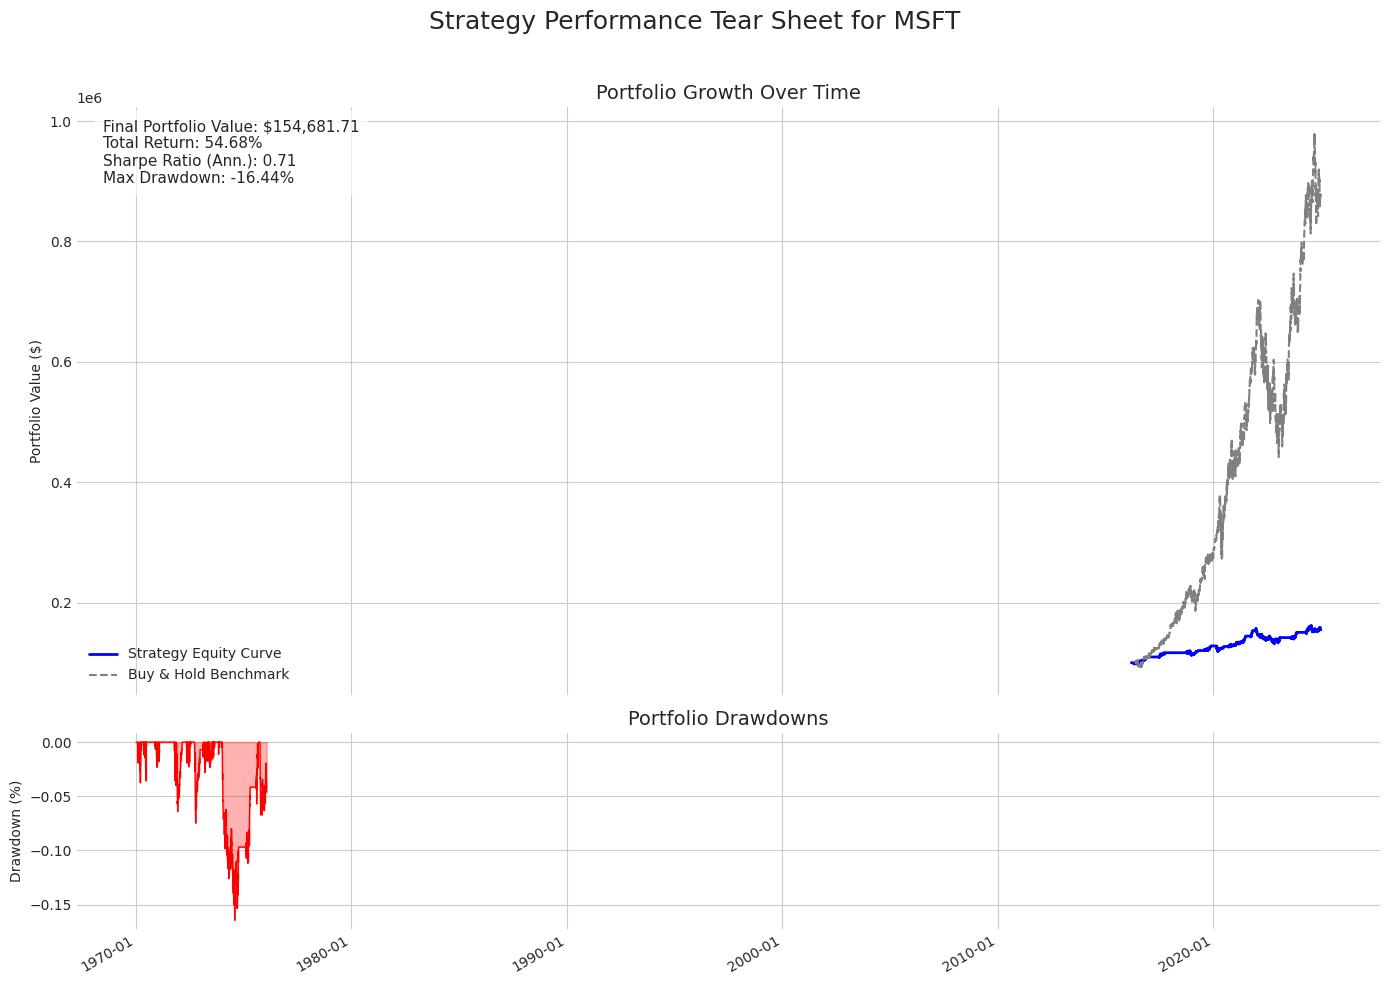

In [41]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_performance_tear_sheet(portfolio_df, ticker_symbol, initial_capital):
    """
    Generates a professional visual tear sheet for the backtest results.
    """
    # --- Step 1: Calculate all necessary metrics from the portfolio history ---
    final_value = portfolio_df['Value'].iloc[-1]
    total_return_pct = (final_value - initial_capital) / initial_capital * 100

    portfolio_df['Daily_Return'] = portfolio_df['Value'].pct_change().fillna(0)
    sharpe_ratio = np.sqrt(252) * portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() if portfolio_df['Daily_Return'].std() != 0 else 0

    rolling_max = portfolio_df['Value'].cummax()
    daily_drawdown = portfolio_df['Value'] / rolling_max - 1.0
    max_drawdown = daily_drawdown.min() * 100

    # --- Step 2: Create the Visualization ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.suptitle(f'Strategy Performance Tear Sheet for {ticker_symbol}', fontsize=18)

    # --- Plot 1: Equity Curve and Buy & Hold Benchmark ---
    ax1.plot(portfolio_df['Date'], portfolio_df['Value'], label='Strategy Equity Curve', color='blue', linewidth=2)
    ax1.plot(portfolio_df['Date'], portfolio_df['Buy_Hold_Value'], label='Buy & Hold Benchmark', color='grey', linestyle='--')
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.set_title('Portfolio Growth Over Time', fontsize=14)
    ax1.legend()
    ax1.grid(True)

    # --- Plot 2: Drawdown Plot ---
    ax2.fill_between(daily_drawdown.index, daily_drawdown, 0, color='red', alpha=0.3)
    ax2.plot(daily_drawdown.index, daily_drawdown, color='red', linewidth=1)
    ax2.set_ylabel('Drawdown (%)')
    ax2.set_title('Portfolio Drawdowns', fontsize=14)
    ax2.grid(True)

    # --- Step 3: Add a Text Box with Key Statistics ---
    stats_text = (
        f"Final Portfolio Value: ${final_value:,.2f}\n"
        f"Total Return: {total_return_pct:.2f}%\n"
        f"Sharpe Ratio (Ann.): {sharpe_ratio:.2f}\n"
        f"Max Drawdown: {max_drawdown:.2f}%"
    )
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7))

    # Improve date formatting
    fig.autofmt_xdate()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'performance_tear_sheet_{ticker_symbol}.png')
    print(f"\nPerformance tear sheet saved as 'performance_tear_sheet_{ticker_symbol}.png'")


def run_backtest_and_visualize(file_path, ticker_symbol, initial_capital=100000.0, risk_per_trade=0.02):
    """
    Runs the backtest and then calls the plotting function.
    """
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)
    ticker_df.dropna(inplace=True)

    if ticker_df.empty or 'ATR_14' not in ticker_df.columns:
        return

    # Backtesting loop...
    cash = initial_capital
    portfolio_value = initial_capital
    holdings = 0
    in_position = False
    portfolio_history = []

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append({'Date': row['Date'], 'Value': portfolio_value})

        # ... (rest of the backtesting logic from previous step) ...
        if in_position and (row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price):
            cash += holdings * row['Close']
            holdings, in_position = 0, False
        elif not in_position and (row['RSI_14'] < 45) and (row['Close'] > row['Open']):
            stop_loss_price = row['Close'] - (2 * row['ATR_14'])
            risk_per_share = row['Close'] - stop_loss_price
            if risk_per_share > 0:
                dollar_risk_amount = portfolio_value * risk_per_trade
                shares_to_buy = dollar_risk_amount / risk_per_share
                entry_value = shares_to_buy * row['Close']
                if cash >= entry_value:
                    holdings, cash, in_position = shares_to_buy, cash - entry_value, True
                    entry_price = row['Close']
                    profit_target_price = entry_price + (3 * risk_per_share)

    portfolio_df = pd.DataFrame(portfolio_history)

    # Add Buy & Hold benchmark for plotting
    portfolio_df['Buy_Hold_Value'] = (ticker_df['Close'] / ticker_df['Close'].iloc[0]) * initial_capital

    # Call the plotting function
    plot_performance_tear_sheet(portfolio_df, ticker_symbol, initial_capital)


# --- Run the Full Analysis and Visualization ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
run_backtest_and_visualize(your_daily_file, 'MSFT')


--- Running Full Analysis for AAPL ---

           Annual Performance Breakdown
      Annual Return %  Sharpe Ratio
Year                               
2016             0.00          0.46
2017            15.65          2.70
2018             2.11          0.27
2019            14.35          1.97
2020             5.05          0.67
2021            10.33          1.58
2022            -8.75         -0.81
2023            10.93          1.58
2024             9.34          1.14

Annual performance chart saved as 'annual_performance_AAPL.png'


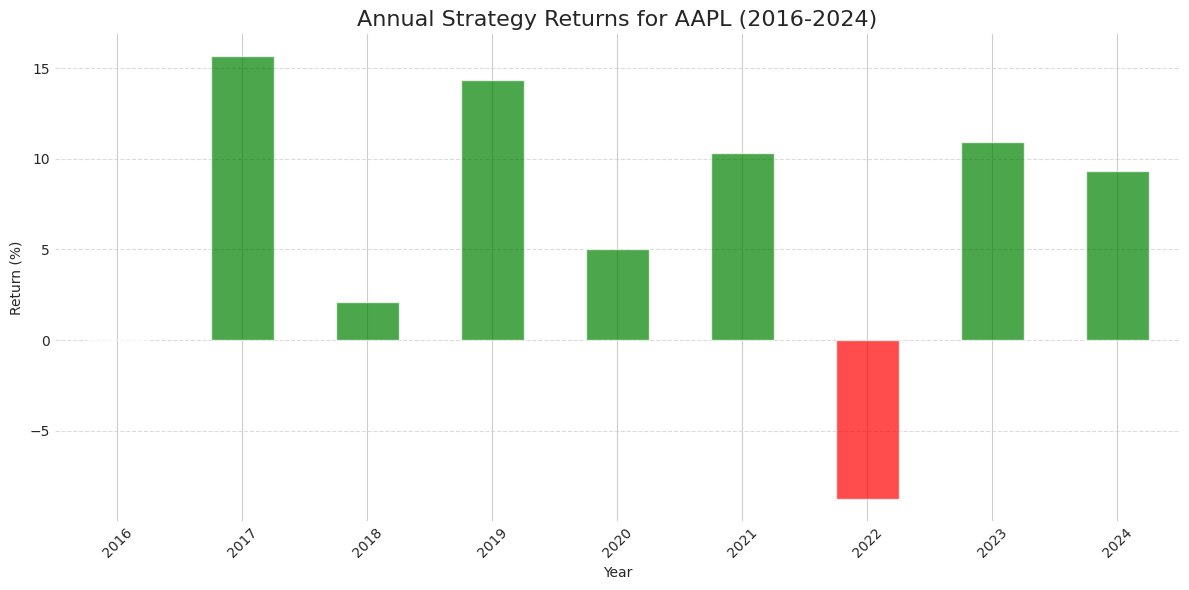

In [42]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def analyze_and_plot_annual_performance(portfolio_df, ticker_symbol, initial_capital):
    """
    Analyzes and plots the year-by-year performance of a backtest.
    """
    # --- Step 1: Calculate Annual Metrics ---
    portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])
    portfolio_df.set_index('Date', inplace=True)

    # Resample to get the value at the end of each year
    annual_values = portfolio_df['Value'].resample('A').last()
    annual_returns = annual_values.pct_change().fillna(0) * 100

    # Calculate annualized Sharpe Ratio for each year
    def annual_sharpe(returns):
        if returns.std() == 0: return 0
        return np.sqrt(252) * returns.mean() / returns.std()

    annual_sharpe_ratios = portfolio_df['Daily_Return'].resample('A').apply(annual_sharpe)

    # Combine into a summary dataframe
    annual_summary = pd.DataFrame({
        'Year': annual_returns.index.year,
        'Annual Return %': annual_returns.values,
        'Sharpe Ratio': annual_sharpe_ratios.values
    }).set_index('Year')

    print("\n" + "="*50)
    print("           Annual Performance Breakdown")
    print("="*50)
    print(annual_summary.round(2))
    print("="*50)

    # --- Step 2: Create the Visualization ---
    plt.figure(figsize=(12, 6))
    annual_summary['Annual Return %'].plot(kind='bar',
                                           color=['green' if x > 0 else 'red' for x in annual_summary['Annual Return %']],
                                           alpha=0.7)

    plt.title(f'Annual Strategy Returns for {ticker_symbol} (2016-2024)', fontsize=16)
    plt.ylabel('Return (%)')
    plt.xlabel('Year')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'annual_performance_{ticker_symbol}.png')
    print(f"\nAnnual performance chart saved as 'annual_performance_{ticker_symbol}.png'")
    plt.show()


def run_backtest_with_annual_analysis(file_path, ticker_symbol, initial_capital=100000.0, risk_per_trade=0.02):
    """
    Main function to run the backtest and then trigger the annual analysis.
    """
    print(f"\n--- Running Full Analysis for {ticker_symbol} ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # Prepare data
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)
    ticker_df.dropna(inplace=True)

    if ticker_df.empty or 'ATR_14' not in ticker_df.columns:
        print(f"Could not process {ticker_symbol} due to missing data.")
        return

    # Backtesting loop...
    cash, portfolio_value, holdings, in_position = initial_capital, initial_capital, 0, False
    portfolio_history = []

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append({'Date': row['Date'], 'Value': portfolio_value})

        if in_position and (row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price):
            cash += holdings * row['Close']
            holdings, in_position = 0, False
        elif not in_position and (row['RSI_14'] < 45) and (row['Close'] > row['Open']):
            stop_loss_price = row['Close'] - (2 * row['ATR_14'])
            risk_per_share = row['Close'] - stop_loss_price
            if risk_per_share > 0:
                dollar_risk_amount = portfolio_value * risk_per_trade
                shares_to_buy = dollar_risk_amount / risk_per_share
                entry_value = shares_to_buy * row['Close']
                if cash >= entry_value:
                    holdings, cash, in_position = shares_to_buy, cash - entry_value, True
                    entry_price = row['Close']
                    profit_target_price = entry_price + (3 * risk_per_share)

    portfolio_df = pd.DataFrame(portfolio_history)
    portfolio_df['Daily_Return'] = portfolio_df['Value'].pct_change()

    # Call the annual analysis function
    analyze_and_plot_annual_performance(portfolio_df, ticker_symbol, initial_capital)


# --- Run the Full Analysis ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
run_backtest_with_annual_analysis(your_daily_file, 'AAPL')


--- Running Backtest to Generate Image for MSFT ---

Static backtest chart saved as 'static_backtest_MSFT.png'


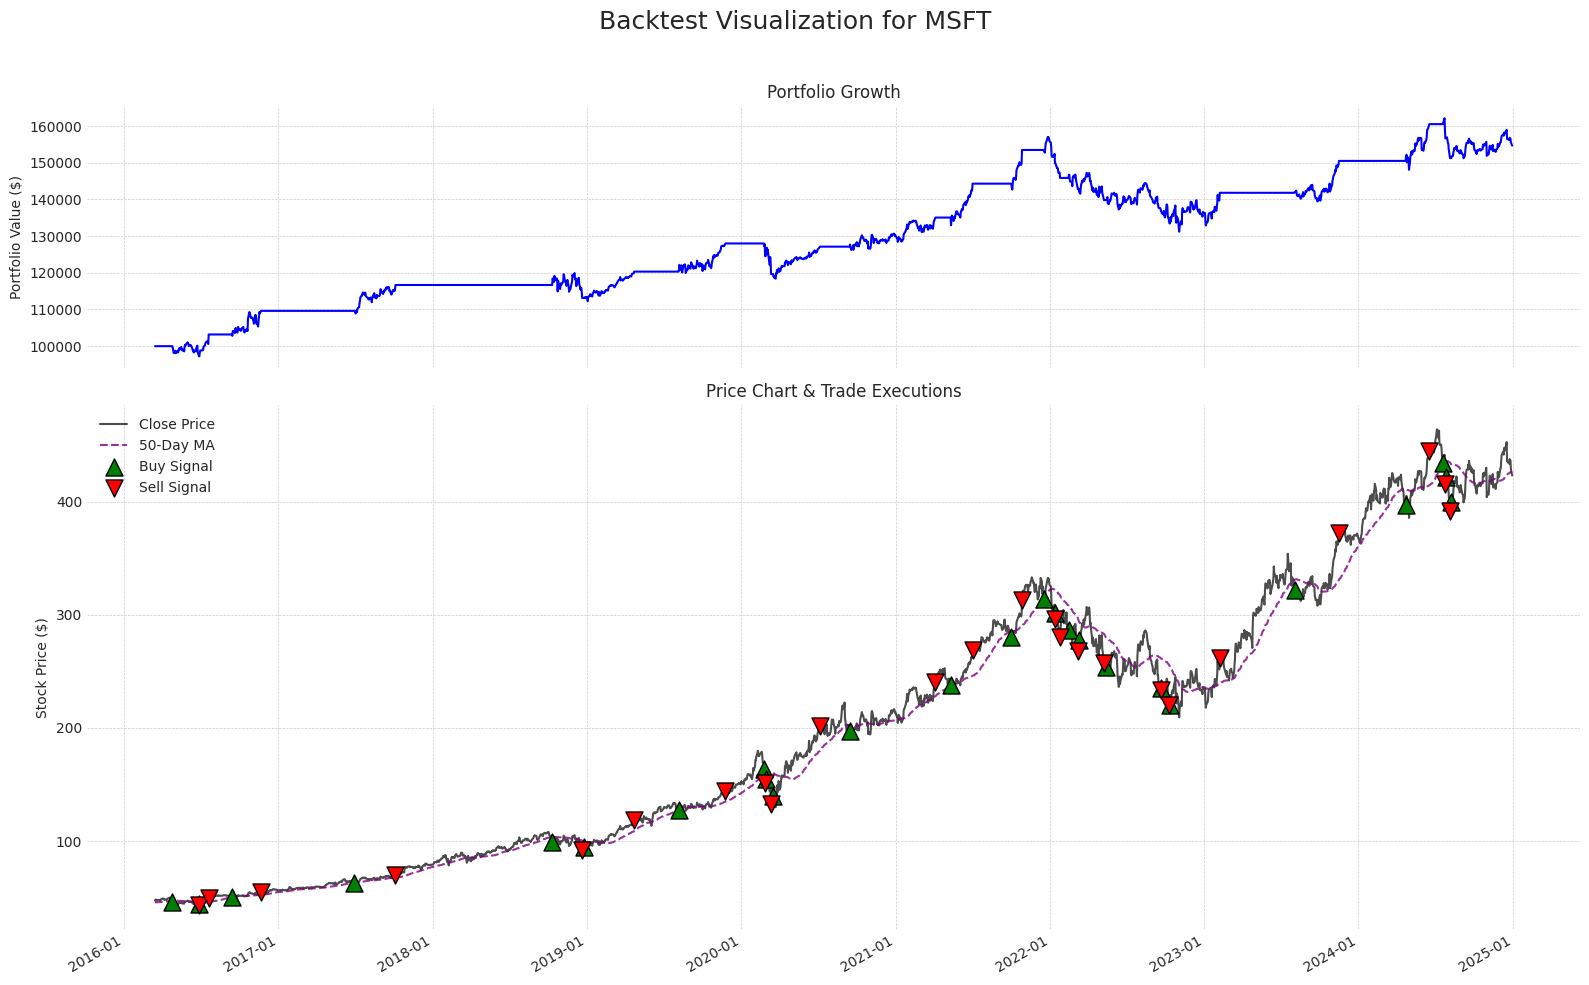

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_static_trade_visualization(ticker_df, portfolio_df, trades_log, ticker_symbol):
    """
    Generates a static PNG image of the backtest results, including the
    equity curve and trade signals on the price chart.
    """
    # Prepare data for plotting trade markers
    trades_df = pd.DataFrame(trades_log)
    buys = trades_df[trades_df['Type'] == 'Buy']
    sells = trades_df[trades_df['Type'] == 'Sell']

    # Create the figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True,
                                   gridspec_kw={'height_ratios': [1, 2]})
    fig.suptitle(f'Backtest Visualization for {ticker_symbol}', fontsize=18)

    # --- Plot 1: Equity Curve ---
    ax1.plot(portfolio_df['Date'], portfolio_df['Value'], label='Strategy Equity Curve', color='blue', zorder=2)
    ax1.set_ylabel('Portfolio Value ($)')
    ax1.set_title('Portfolio Growth')
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Plot 2: Price Chart with Trade Signals ---
    ax2.plot(ticker_df['Date'], ticker_df['Close'], label='Close Price', color='black', alpha=0.7, zorder=2)
    ax2.plot(ticker_df['Date'], ticker_df['MA_50'], label='50-Day MA', color='purple', linestyle='--', alpha=0.8, zorder=3)

    # Plot buy and sell signals
    ax2.scatter(buys['Date'], buys['Price'], label='Buy Signal', marker='^', color='green', s=150, edgecolors='black', zorder=5)
    ax2.scatter(sells['Date'], sells['Price'], label='Sell Signal', marker='v', color='red', s=150, edgecolors='black', zorder=5)

    ax2.set_ylabel('Stock Price ($)')
    ax2.set_title('Price Chart & Trade Executions')
    ax2.legend()
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Improve date formatting
    fig.autofmt_xdate()
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Save the static image
    output_filename = f'static_backtest_{ticker_symbol}.png'
    plt.savefig(output_filename)
    print(f"\nStatic backtest chart saved as '{output_filename}'")
    plt.show()


def run_backtest_and_generate_image(file_path, ticker_symbol, initial_capital=100000.0, risk_per_trade=0.02):
    """
    Runs the backtest and then calls the static image plotting function.
    """
    print(f"\n--- Running Backtest to Generate Image for {ticker_symbol} ---")
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found. Please upload the file to proceed.")
        return

    # --- Data Preparation ---
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)
    df.dropna(subset=['Date'], inplace=True)
    ticker_df = df[df['Ticker'] == ticker_symbol].copy()
    ticker_df.sort_values('Date', inplace=True)
    ticker_df.reset_index(drop=True, inplace=True)

    if ticker_df.empty or 'ATR_14' not in ticker_df.columns or 'RSI_14' not in ticker_df.columns:
        print(f"Could not process {ticker_symbol} due to missing data.")
        return
    ticker_df.dropna(inplace=True)

    # --- Backtesting Simulation with Detailed Logging ---
    cash, portfolio_value, holdings, in_position = initial_capital, initial_capital, 0, False
    portfolio_history = []
    trades_log = []

    for i, row in ticker_df.iterrows():
        portfolio_value = cash + holdings * row['Close'] if in_position else cash
        portfolio_history.append({'Date': row['Date'], 'Value': portfolio_value})

        if in_position:
            if row['Close'] <= stop_loss_price or row['Close'] >= profit_target_price:
                cash += holdings * row['Close']
                trades_log.append({'Date': row['Date'], 'Type': 'Sell', 'Price': row['Close']})
                holdings, in_position = 0, False

        elif not in_position:
            is_oversold_ish = row['RSI_14'] < 45
            is_reversing = row['Close'] > row['Open']
            if is_oversold_ish and is_reversing:
                stop_loss_price = row['Close'] - (2 * row['ATR_14'])
                risk_per_share = row['Close'] - stop_loss_price
                if risk_per_share > 0:
                    dollar_risk_amount = portfolio_value * risk_per_trade
                    shares_to_buy = dollar_risk_amount / risk_per_share
                    entry_value = shares_to_buy * row['Close']
                    if cash >= entry_value:
                        holdings, cash, in_position = shares_to_buy, cash - entry_value, True
                        entry_price = row['Close']
                        profit_target_price = entry_price + (3 * risk_per_share)
                        trades_log.append({'Date': row['Date'], 'Type': 'Buy', 'Price': entry_price})

    portfolio_df = pd.DataFrame(portfolio_history)

    # Call the plotting function
    plot_static_trade_visualization(ticker_df, portfolio_df, trades_log, ticker_symbol)


# --- This code is ready to run once the file is uploaded ---
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
run_backtest_and_generate_image(your_daily_file, 'MSFT')

--- Running Portfolio-Level Backtest ---

--- Portfolio Backtest Report ---
Final Portfolio Value: $3,081,630.98
Total Return: 2981.63%
Sharpe Ratio (Annualized): 1.33
Maximum Drawdown: -48.56%

Portfolio backtest chart saved as 'portfolio_backtest.png'


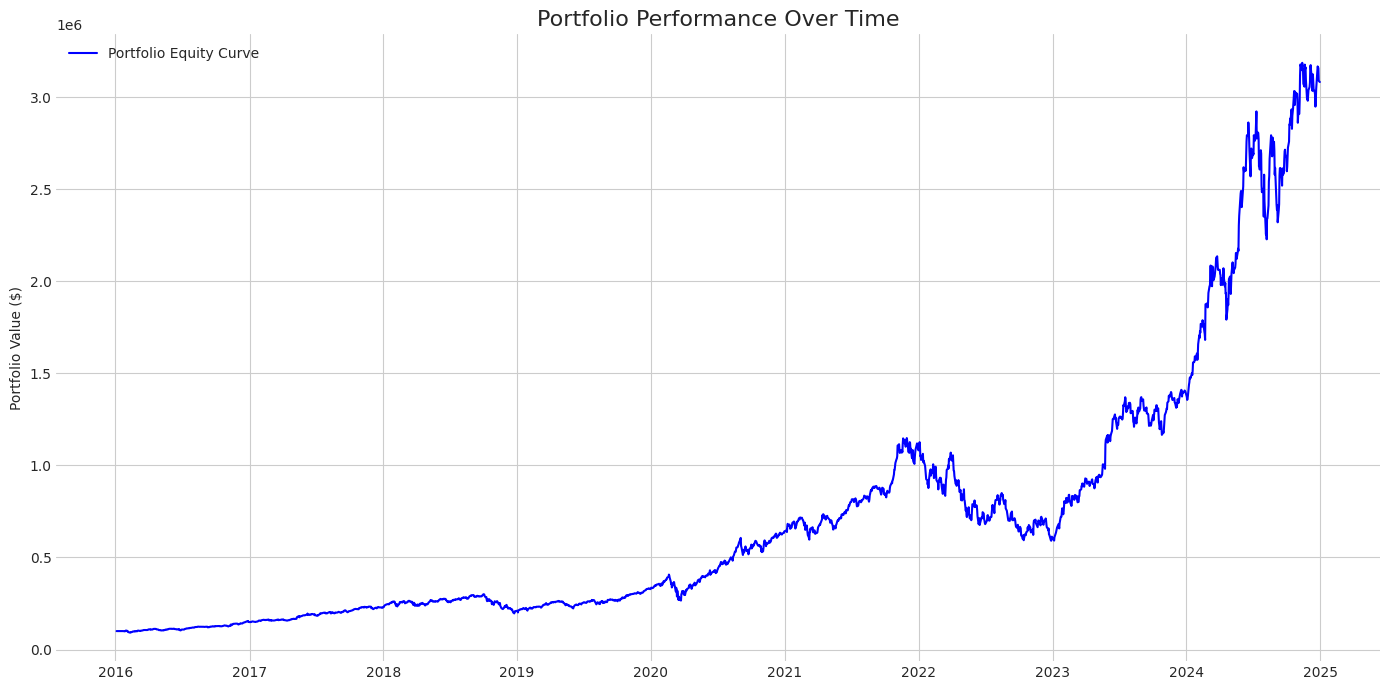

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_portfolio_backtest(file_path, tickers_list, initial_capital=100000.0, risk_per_trade_pct=0.01):
    """
    Runs a backtest on a portfolio of stocks, managing a single pool of capital.
    """
    print("--- Running Portfolio-Level Backtest ---")
    try:
        df_full = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare Data ---
    df_full['Date'] = pd.to_datetime(df_full['Date'], errors='coerce', utc=True)
    df_full.dropna(subset=['Date'], inplace=True)
    df_full.sort_values('Date', inplace=True)

    price_pivot = df_full.pivot(index='Date', columns='Ticker', values='Close')
    rsi_pivot = df_full.pivot(index='Date', columns='Ticker', values='RSI_14')
    atr_pivot = df_full.pivot(index='Date', columns='Ticker', values='ATR_14')
    open_pivot = df_full.pivot(index='Date', columns='Ticker', values='Open')

    # --- Step 2: The Portfolio Simulation Loop ---
    cash = initial_capital
    portfolio_history = []
    positions = {} # To hold trade data for each ticker

    for date in price_pivot.index:
        holdings_value = 0
        # --- FIXED: Correctly access the number of shares from the positions dictionary ---
        for ticker, position_data in positions.items():
            if not np.isnan(price_pivot.loc[date, ticker]):
                holdings_value += position_data['shares'] * price_pivot.loc[date, ticker]

        portfolio_value = cash + holdings_value
        portfolio_history.append({'Date': date, 'Value': portfolio_value})

        # --- Check for Exit Signals across all open positions ---
        for ticker in list(positions.keys()):
            # Using a simple 15% trailing stop from entry for this model
            if not np.isnan(price_pivot.loc[date, ticker]) and \
               price_pivot.loc[date, ticker] <= positions[ticker]['entry_price'] * 0.85:
                # Sell
                cash += positions[ticker]['shares'] * price_pivot.loc[date, ticker]
                del positions[ticker]

        # --- Check for Entry Signals across all tickers in our list ---
        for ticker in tickers_list:
            if ticker in positions: continue
            if np.isnan(rsi_pivot.loc[date, ticker]) or np.isnan(atr_pivot.loc[date, ticker]) or np.isnan(price_pivot.loc[date, ticker]) or np.isnan(open_pivot.loc[date, ticker]):
                continue

            is_oversold_ish = rsi_pivot.loc[date, ticker] < 45
            is_reversing = price_pivot.loc[date, ticker] > open_pivot.loc[date, ticker]

            if is_oversold_ish and is_reversing:
                stop_loss_price = price_pivot.loc[date, ticker] - (2 * atr_pivot.loc[date, ticker])
                risk_per_share = price_pivot.loc[date, ticker] - stop_loss_price
                if risk_per_share <= 0: continue

                dollar_risk = portfolio_value * risk_per_trade_pct
                shares_to_buy = dollar_risk / risk_per_share
                entry_value = shares_to_buy * price_pivot.loc[date, ticker]

                if cash >= entry_value:
                    positions[ticker] = {'shares': shares_to_buy, 'entry_price': price_pivot.loc[date, ticker]}
                    cash -= entry_value

    # --- Step 3: Final Analysis and Visualization ---
    portfolio_df = pd.DataFrame(portfolio_history).set_index('Date')
    final_value = portfolio_df['Value'].iloc[-1]
    total_return_pct = (final_value - initial_capital) / initial_capital * 100

    portfolio_df['Daily_Return'] = portfolio_df['Value'].pct_change()
    sharpe_ratio = np.sqrt(252) * portfolio_df['Daily_Return'].mean() / portfolio_df['Daily_Return'].std() if portfolio_df['Daily_Return'].std() != 0 else 0

    rolling_max = portfolio_df['Value'].cummax()
    daily_drawdown = portfolio_df['Value'] / rolling_max - 1.0
    max_drawdown = daily_drawdown.min() * 100

    print("\n--- Portfolio Backtest Report ---")
    print(f"Final Portfolio Value: ${final_value:,.2f}")
    print(f"Total Return: {total_return_pct:.2f}%")
    print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")

    plt.figure(figsize=(14, 7))
    plt.plot(portfolio_df.index, portfolio_df['Value'], label='Portfolio Equity Curve', color='blue')
    plt.title('Portfolio Performance Over Time', fontsize=16)
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('portfolio_backtest.png')
    print("\nPortfolio backtest chart saved as 'portfolio_backtest.png'")
    plt.show()

# --- Run the Portfolio Backtest ---
tickers_to_trade = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'NVDA', 'JPM', 'JNJ', 'V', 'PG']
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
run_portfolio_backtest(your_daily_file, tickers_to_trade)

In [49]:
import pandas as pd
import numpy as np

def run_genetic_portfolio_optimizer(file_path, tickers_list, population_size=100, generations=50, mutation_rate=0.01):
    """
    Uses a Genetic Algorithm to find the optimal portfolio weights to maximize the Sharpe Ratio.
    """
    print("--- Running Genetic Algorithm for Portfolio Optimization ---")
    try:
        df_full = pd.read_csv(file_path, parse_dates=['Date'])
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return

    # --- Step 1: Prepare the Data ---
    # Create a monthly returns dataframe for our chosen tickers
    # FIXED: Use the 'Date' column as the index in pivot
    price_pivot = df_full.pivot(index='Date', columns='Ticker', values='Close')
    monthly_returns = price_pivot[tickers_list].resample('M').last().pct_change().dropna()

    # Calculate mean returns and the covariance matrix (key inputs for portfolio stats)
    mean_returns = monthly_returns.mean()
    cov_matrix = monthly_returns.cov()

    # --- Step 2: Define the Genetic Algorithm Functions ---

    def create_individual(n_assets):
        # Create a random portfolio (weights must sum to 1)
        weights = np.random.random(n_assets)
        return weights / np.sum(weights)

    def create_population(n_individuals, n_assets):
        return [create_individual(n_assets) for _ in range(n_individuals)]

    def calculate_fitness(weights, mean_returns, cov_matrix):
        # The fitness function is the Sharpe Ratio
        portfolio_return = np.sum(mean_returns * weights) * 12 # Annualized
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(12) # Annualized
        sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility != 0 else 0
        return sharpe_ratio

    def selection(population, fitness_scores):
        # Select the top 20% of the population to be parents
        top_performers_indices = np.argsort(fitness_scores)[-int(0.2 * len(population)):]
        return [population[i] for i in top_performers_indices]

    def crossover(parent1, parent2):
        # Create a child by randomly mixing weights from two parents
        child = parent1.copy()
        for i in range(len(child)):
            if np.random.rand() > 0.5:
                child[i] = parent2[i]
        return child / np.sum(child) # Re-normalize to ensure weights sum to 1

    def mutation(individual, rate):
        # Randomly change a small part of the portfolio
        if np.random.rand() < rate:
            random_index = np.random.randint(len(individual))
            individual[random_index] = np.random.rand()
        return individual / np.sum(individual) # Re-normalize

    # --- Step 3: Run the Evolution ---
    n_assets = len(tickers_list)
    population = create_population(population_size, n_assets)

    for generation in range(generations):
        fitness_scores = [calculate_fitness(ind, mean_returns, cov_matrix) for ind in population]
        parents = selection(population, fitness_scores)

        # Create the next generation
        next_generation = parents # Keep the elite
        while len(next_generation) < population_size:
            parent1, parent2 = np.random.choice(len(parents), 2, replace=False)
            child = crossover(parents[parent1], parents[parent2])
            child = mutation(child, mutation_rate)
            next_generation.append(child)

        population = next_generation
        print(f"Generation {generation+1}/{generations} - Best Sharpe Ratio: {max(fitness_scores):.2f}")

    # --- Step 4: Present the Final Optimized Portfolio ---
    final_fitness_scores = [calculate_fitness(ind, mean_returns, cov_matrix) for ind in population]
    best_individual = population[np.argmax(final_fitness_scores)]
    best_fitness = max(final_fitness_scores)

    print("\n" + "="*50)
    print("      Optimized Portfolio Found")
    print("="*50)
    print(f"Optimal Sharpe Ratio: {best_fitness:.4f}")
    print("\nOptimal Asset Allocation:")
    for i, ticker in enumerate(tickers_list):
        print(f"  > {ticker}: {best_individual[i]*100:.2f}%")
    print("="*50)

# --- Run the Optimizer ---
# A diverse list of tickers for portfolio construction
portfolio_tickers = ['AAPL', 'MSFT', 'JNJ', 'JPM', 'XOM', 'PG']
your_daily_file = '/content/sp500_full_dataset_2016_2024.csv'
run_genetic_portfolio_optimizer(your_daily_file, portfolio_tickers)

--- Running Genetic Algorithm for Portfolio Optimization ---


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'